# Loading packages

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext rpy2.ipython

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.api import SVAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, CointRankResults, VECM, select_coint_rank

from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_arch, het_breuschpagan, het_white
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests, q_stat, coint
from arch.unitroot import PhillipsPerron, ZivotAndrews, DFGLS, KPSS, ADF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import pandas_datareader.data as web
from scipy.stats import yeojohnson


plt.style.use('seaborn-white')
start = datetime.datetime(1987, 1, 1)
end = datetime.datetime(2019, 7, 1)

/home/gpetrini/.local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:15: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/gpetrini/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading data

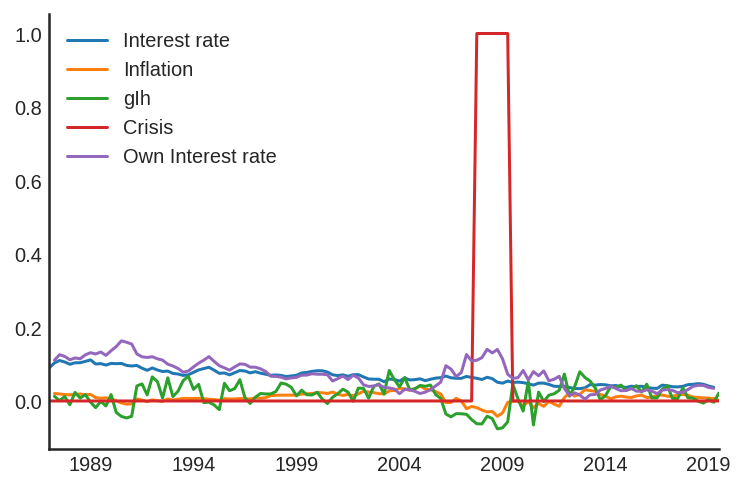

Interest rate  Inflation       gIh  Crisis  Own Interest rate  \
                                                                            
1987-09-30         0.1102   0.018990  0.001110       0           0.125992   
1987-12-31         0.1061   0.017522  0.011925       0           0.121367   
1988-03-31         0.0999   0.016564 -0.010302       0           0.112063   
1988-06-30         0.1040   0.017787  0.023392       0           0.117025   
1988-09-30         0.1042   0.019070  0.007998       0           0.114886   

            d_Own Interest rate     d_gIh  d_Inflation  d_Interest rate  
                                                                         
1987-09-30             0.015072 -0.011713    -0.001501           0.0067  
1987-12-31            -0.004625  0.010815    -0.001468          -0.0041  
1988-03-31            -0.009304 -0.022228    -0.000958          -0.0062  
1988-06-30             0.004962  0.033694     0.001223           0.0041  
1988-09-30            -0.002138 -0.015394     0.001283           0.0002

In [2]:
df = web.DataReader(
    [
        "PRFI",
        "CSUSHPISA",
        "MORTGAGE30US",
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    "Residential Investment", 
    "House Prices", 
    "Interest rate",
]
df.index.name = ""

df['Interest rate'] = df['Interest rate'].divide(100)
df = df.resample('M').last()
df['House Prices'] = df['House Prices']/df['House Prices'][0]
df = df.resample('Q').last()

df["Inflation"] = df["House Prices"].pct_change() # Warning: 4
df['gIh'] = df["Residential Investment"].pct_change() # Warning: 4
df["Own Interest rate"] = ((1+df["Interest rate"])/(1+df["Inflation"])) -1

df['Own Interest rate'], *_ = yeojohnson(df['Own Interest rate'])
#df['Inflation'], *_ = yeojohnson(df['Inflation'])
df['gIh'], *_ = yeojohnson(df['gIh'])

df[["Inflation", "gIh", "Own Interest rate", "Interest rate"]].to_csv("../data/Complete_Data")

df["Crisis"] = [0 for i in range(len(df["gIh"]))]
for i in range(len(df["Crisis"])):
    if df.index[i] > datetime.datetime(2007,12,1) and df.index[i] < datetime.datetime(2009,7,1):
        df["Crisis"][i] = 1

df = df[["Interest rate", "Inflation", "gIh", "Crisis", "Own Interest rate"]]
df.plot()
sns.despine()
plt.show()

df["d_Own Interest rate"] = df["Own Interest rate"].diff()
df["d_gIh"] = df["gIh"].diff()
df["d_Inflation"] = df["Inflation"].diff()
df["d_Interest rate"] = df['Interest rate'].diff()
df = df.dropna()
df.head()

# Functions

## Unit root test

In [3]:
def testes_raiz(df=df["gIh"], original_trend='c', diff_trend='c'):
    """
    serie: Nome da coluna do df
    orignal_trend: 'c', 'ct', 'ctt'
    diff_trend: 'c', 'ct', 'ctt'
    
    Plota série o original e em diferenta e retorna testes de raíz unitária
    """
    fig, ax = plt.subplots(1,2)

    df.plot(ax=ax[0], title='Original series')
    df.diff().plot(ax=ax[1], title='First differences')

    plt.tight_layout()
    sns.despine()
    plt.show()
    
    fig, ax = plt.subplots(2,2)
    
    plot_acf(df, ax=ax[0,0], title='ACF: serie original') 
    plot_pacf(df, ax=ax[0,1], title='PACF: serie original')
    
    plot_acf(df.diff().dropna(), ax=ax[1,0], title='ACF: serie em diferença') 
    plot_pacf(df.diff().dropna(), ax=ax[1,1], title='PACF: serie em diferença')
    
    plt.tight_layout()
    sns.despine() 
    plt.show()

    
    # Zivot Andrews
    print('\nZIVOT ANDREWS level series')
    print(ZivotAndrews(df, trend = original_trend).summary(),"\n")
    print('\nZIVOT ANDREWS First differences')
    print(ZivotAndrews(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nADF level series')
    print(ADF(df, trend=original_trend).summary(),"\n")
    print('\nADF First differences')
    print(ADF(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nDFGLS level series')
    print(DFGLS(df, trend=original_trend).summary(),"\n")
    print('\nDFGLS First differences')
    print(DFGLS(df.diff().dropna(), trend=diff_trend).summary(),"\n")
    
    print('\nKPSS em nível')
    print(KPSS(df, trend = original_trend).summary(),"\n")
    print('\nKPSS em primeira diferença')
    print(KPSS(df.diff().dropna(), trend = diff_trend).summary(),"\n")
    
    print('\nPhillips Perron em nível')
    print(PhillipsPerron(df, trend=original_trend).summary(),"\n")
    print('\nPhillips Perron em primeira diferença')
    print(PhillipsPerron(df.diff().dropna(), trend=diff_trend).summary(),"\n")

## Engel-Granger and Johansen cointegration test

In [4]:
# Teste de cointegração

def cointegracao(ts0, ts1, signif = 0.05, lag=1):
  trends = ['nc', 'c', 'ct', 'ctt']
  for trend in trends:
    print(f"\nTestando para lag = {lag} e trend = {trend}")
    result = coint(ts0, ts1, trend = trend, maxlag=lag)
    print('Null Hypothesis: there is NO cointegration')
    print('Alternative Hypothesis: there IS cointegration')
    print('t Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    if result[1] < signif:
      print('CONCLUSION: REJECT null Hypothesis: there IS cointegration\n')
    else:
      print('CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration\n')
    
def testes_coint(series, maxlag=6, signif = 0.05,):
    for i in range(1, maxlag):
        print(50*'=')
        cointegracao(
            ts0=series.iloc[:, 0],
            ts1=series.iloc[:, 1:],
            signif=signif,
            lag=i
        )
        print("\nTESTE DE JOHANSEN\n")
        print("Teste SEM constante")
        result = select_coint_rank(endog=series, k_ar_diff=i, det_order=-1, signif=signif) ## Warning: 1
        print(result.summary())
        print(f'Para lag = {i} e significância = {signif*100}%, Rank = {result.rank}')
        print("\nTeste COM constante\n")
        result = select_coint_rank(endog=series, k_ar_diff=i, det_order=0, signif=signif) ## Warning: 1
        print(result.summary())
        print(f'Para lag = {i} e significância = {signif*100}%, Rank = {result.rank}')
        print("\nTeste COM constante E tendência\n")
        result = select_coint_rank(endog=series, k_ar_diff=i, det_order=1, signif=signif) ## Warning: 1
        print(result.summary())
        print(f'Para lag = {i} e significância = {signif*100}%, Rank = {result.rank}')
        print(10*'=')

## Resuduals analysis: Ljung-Box and Box-Pierce

In [5]:
### Resíduos

def LjungBox_Pierce(resid, signif = 0.05, boxpierce = False, k = 4):
  """
  resid = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: autocorrelations up to lag k equal zero")
  print('H1: autocorrelations up to lag k not zero')
  print("Box-Pierce: ", boxpierce)
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper(), ". Considering a significance level of",  signif*100,"%")
    result = acorr_ljungbox(x = resid.iloc[:,i-1], lags = k, boxpierce = boxpierce)[i-1]
    conclusion = result < signif
    for j in range(k):
      print(f'p-value = {result[j]}')
      print("Reject H0 on lag " ,j+1,"? ", conclusion[j], "\n")
    print("\n")
    
def ARCH_LM(resid, signif = 0.05, autolag = 'bic'):
  """
  df = residuals df
  signif = signif. level
  """
  var = len(resid.columns)
  print("H0: Residuals are homoscedastic")
  print('H1: Residuals are heteroskedastic')
  
  for i in range(var):
    print("Testing for ", resid.columns[i].upper())
    result = het_arch(resid = resid.iloc[:,i], autolag = autolag)
    print('LM statistic: ', result[0])
    print('LM p-value: ', result[1])
    print("Reject H0? ", result[1] < signif)
    print('F statistic: ', result[2])
    print('F p-value: ', result[3])
    print("Reject H0? ", result[3] < signif)
    print('\n')
    

def analise_residuos(results, nmax=15):
    
    residuals = pd.DataFrame(results.resid, columns = results.names)
    
    residuals.plot()
    sns.despine()
    plt.show()
    
    for serie in residuals.columns:
        sns.set_context('talk')
        fig, ax = plt.subplots(1,2, figsize=(10,8))

        plot_acf(residuals[serie], ax=ax[0], title=f'ACF Resíduo de {serie}', zero=False) 
        plot_pacf(residuals[serie], ax=ax[1], title=f'PACF Resíduo de {serie}', zero=False)
        
        plt.tight_layout()
        sns.despine() 
        plt.show()

    print('AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU\n')
    print(results.test_whiteness(nlags=nmax).summary())
    print('\nAUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO\n')
    print(results.test_whiteness(nlags=nmax, adjusted=True).summary())
    print('\nLJUNGBOX\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=False)
    print('\nBOXPIERCE\n')
    LjungBox_Pierce(residuals, k = 12, boxpierce=True)
    print('\nNORMALIDADE\n')
    print(results.test_normality().summary())
    print('\nHOMOCEDASTICIDADE\n')
    ARCH_LM(residuals)
    
    return residuals
    

In [6]:
results = []
def plot_lags(results = results, trimestres=[2, 5]):
    series = results.names
    sns.set_context('talk')
    fig, ax = plt.subplots(len(trimestres),2, figsize = (16,10))
    
    for i in range(len(trimestres)):
        sns.regplot(y = df[series[0]], x = df[series[1]].shift(-trimestres[i]), color = 'black', ax = ax[i,0], order = 2)
        ax[i,0].set_xlabel(f'{series[1]} lagged in {trimestres[i]} quarters')

        sns.regplot(x = df[series[0]].shift(-trimestres[i]), y = df[series[1]], color = 'black', ax = ax[i,1], order = 2)
        ax[i,1].set_xlabel(f'{series[0]} lagged in {trimestres[i]} quarters')
        
    plt.tight_layout()
    
    return fig

## FEVD for VECM

In [7]:
from statsmodels.compat.python import lrange, iteritems
from statsmodels.tsa.vector_ar import output, plotting, util
def fmse(self, steps):
        r"""
        Compute theoretical forecast error variance matrices

        Parameters
        ----------
        steps : int
            Number of steps ahead

        Notes
        -----
        .. math:: \mathrm{MSE}(h) = \sum_{i=0}^{h-1} \Phi \Sigma_u \Phi^T

        Returns
        -------
        forc_covs : ndarray (steps x neqs x neqs)
        """
        ma_coefs = self.ma_rep(steps)

        k = len(self.sigma_u)
        forc_covs = np.zeros((steps, k, k))

        prior = np.zeros((k, k))
        for h in range(steps):
            # Sigma(h) = Sigma(h-1) + Phi Sig_u Phi'
            phi = ma_coefs[h]
            var = phi @ self.sigma_u @ phi.T
            forc_covs[h] = prior = prior + var

        return forc_covs

class FEVD(object):
    """
    Compute and plot Forecast error variance decomposition and asymptotic
    standard errors
    """
    def __init__(self, model, P=None, periods=None):

        self.periods = periods

        self.model = model
        self.neqs = model.neqs
        self.names = model.model.endog_names

        self.irfobj = model.irf(periods=periods)
        self.orth_irfs = self.irfobj.orth_irfs

        # cumulative impulse responses
        irfs = (self.orth_irfs[:periods] ** 2).cumsum(axis=0)

        rng = lrange(self.neqs)
        mse = fmse(self.model, periods)[:, rng, rng]

        # lag x equation x component
        fevd = np.empty_like(irfs)

        for i in range(periods):
            fevd[i] = (irfs[i].T / mse[i]).T

        # switch to equation x lag x component
        self.decomp = fevd.swapaxes(0, 1)

    def summary(self):
        buf = StringIO()

        rng = lrange(self.periods)
        for i in range(self.neqs):
            ppm = output.pprint_matrix(self.decomp[i], rng, self.names)

            buf.write('FEVD for %s\n' % self.names[i])
            buf.write(ppm + '\n')

        print(buf.getvalue())


    def plot(self, periods=None, figsize=(10, 10), **plot_kwds):
        """Plot graphical display of FEVD

        Parameters
        ----------
        periods : int, default None
            Defaults to number originally specified. Can be at most that number
        """
        import matplotlib.pyplot as plt

        k = self.neqs
        periods = periods or self.periods

        fig, axes = plt.subplots(nrows=k, figsize=figsize)

        #fig.suptitle('Forecast error variance decomposition (FEVD)')

        colors = ["black", "lightgray"]
        ticks = np.arange(periods)

        limits = self.decomp.cumsum(2)

        for i in range(k):
            ax = axes[i]

            this_limits = limits[i].T

            handles = []

            for j in range(k):
                lower = this_limits[j - 1] if j > 0 else 0
                upper = this_limits[j]
                handle = ax.bar(ticks, upper - lower, bottom=lower,
                                color=colors[j], label=self.names[j],
                                **plot_kwds)

                handles.append(handle)
            ax.axhline(y=0.5, color = 'red', ls = '--', lw=3)
            
            ax.set_title(self.names[i])

        # just use the last axis to get handles for plotting
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        plotting.adjust_subplots(right=0.85)
        sns.despine()
        return fig


# Strucutural break test

In [8]:
%%R
library(strucchange)
library(urca)
library(dplyr)

df <- read.csv(
  "../data/Complete_Data.csv",
  encoding="UTF-8", 
  stringsAsFactors=FALSE
  )
df <- ts(data = df, start = c(1987,01), frequency = 4)
df <- zoo::na.locf0(df)
colnames(df) <- c("X", "Infla", "gIh", "Own", "Interest rate")

## Taxa de crescimento do Residential investment


result = breakpoints(gIh~1, data=df)
result$breakpoints %>% unique() %>% na.omit() %>% c() -> breaks

for(i in breaks){
  print(paste0("Testando para i = ", index(df)[i]))
  strucchange::sctest(gIh~1, data=df, point=i, type="Chow") %>% print()
}


## Own Interest rate


result = breakpoints(Own~1, data=df)
result$breakpoints %>% unique() %>% na.omit() %>% c() -> breaks

for(i in breaks){
  print(paste0("Testando para i = ", index(df)[i]))
  strucchange::sctest(Own~1, data=df, point=i, type="Chow") %>% print()
}


## Interest rate


result = breakpoints(Interest rate~1, data=df)
result$breakpoints %>% unique() %>% na.omit() %>% c() -> breaks

for(i in breaks){
  print(paste0("Testando para i = ", index(df)[i]))
  strucchange::sctest(Interest rate~1, data=df, point=i, type="Chow") %>% print()
}


## Inflation


result = breakpoints(Infla~1, data=df)
result$breakpoints %>% unique() %>% na.omit() %>% c() -> breaks

for(i in breaks){
  print(paste0("Testando para i = ", index(df)[i]))
  strucchange::sctest(Infla~1, data=df, point=i, type="Chow") %>% print()
}

R[write to console]: Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:41:31: unexpected symbol
40: 
41: result = breakpoints(Interest rate
                                  ^




Error in (function (file = "", n = NULL, text = NULL, prompt = "?", keep.source = getOption("keep.source"),  : 
  <text>:41:31: unexpected symbol
40: 
41: result = breakpoints(Interest rate
                                  ^


Selecionando série para depois de 1991

In [9]:
df = df["1992-01-01":]
df[["Inflation", "gIh", "Own Interest rate", "Interest rate"]].to_csv("../data/Data_yeojohnson.csv")


df[["Inflation", "gIh", "Own Interest rate", "Interest rate"]].to_csv(
    "../data/Data_yeojohnson_ascii.csv", 
    encoding='ascii', 
    header = [
        'infla',
        'gIh',
        'Own',
        'Interest rate',
          ], 
         )


# Unit root test

## Housing ($g_{I_h}$)

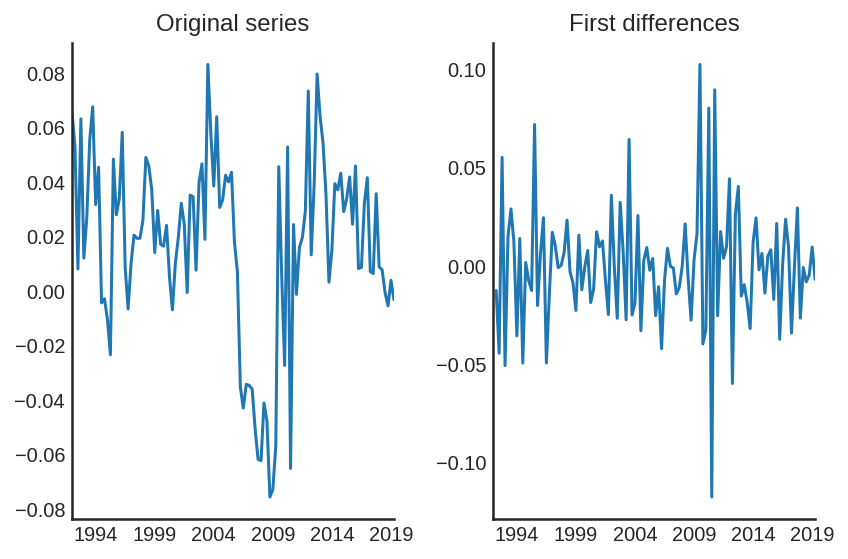

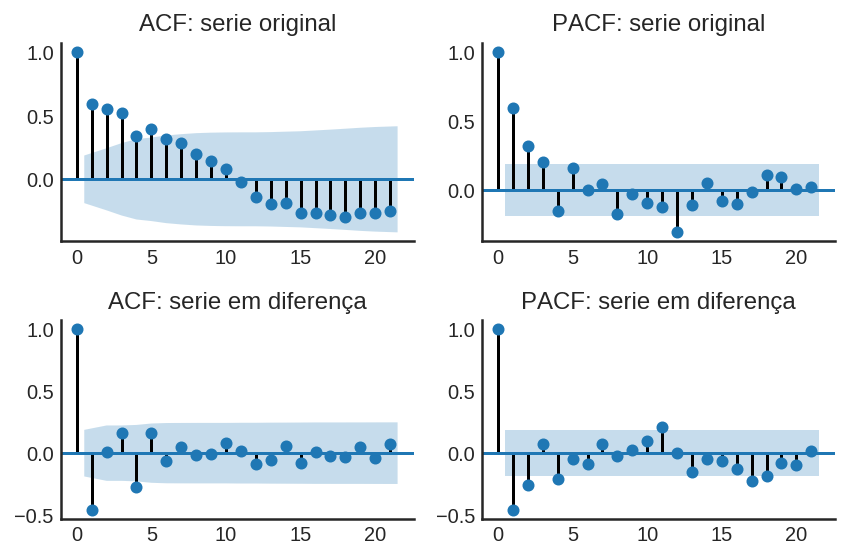


ZIVOT ANDREWS level series
        Zivot-Andrews Results        
Test Statistic                 -4.439
P-value                         0.139
Lags                               11
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS First differences
        Zivot-Andrews Results        
Test Statistic                 -7.739
P-value                         0.000
Lags                                3
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF level series
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.333
P-value                

In [10]:
testes_raiz(df=df['gIh'])

**Conclusão:** Série  não é fracamente estacionária.

## Own interest rate

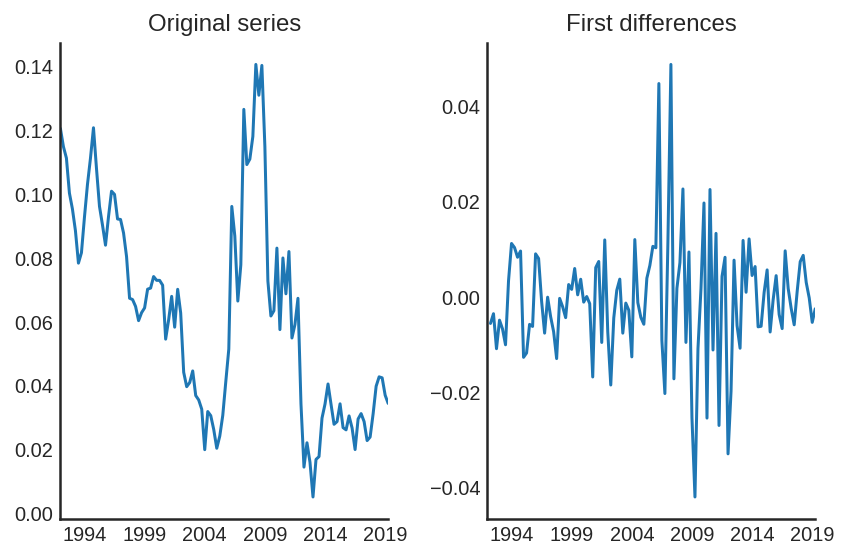

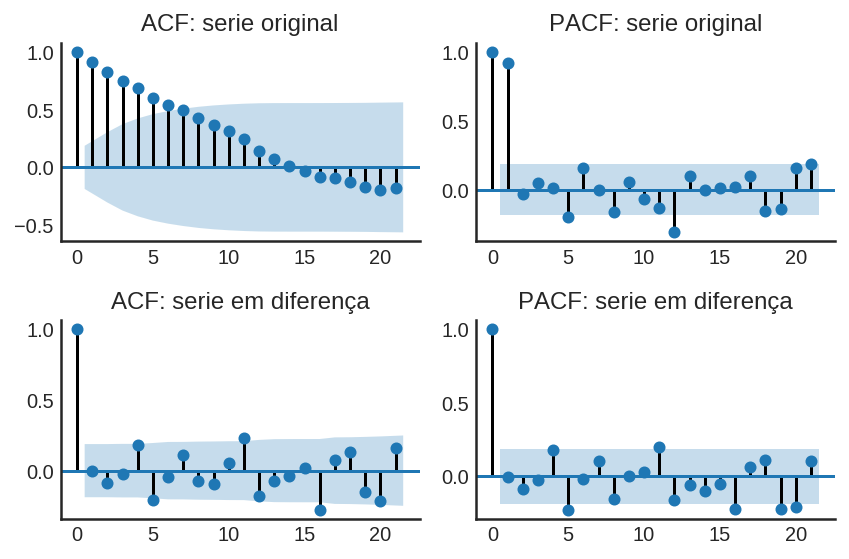


ZIVOT ANDREWS level series
        Zivot-Andrews Results        
Test Statistic                 -4.206
P-value                         0.236
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS First differences
        Zivot-Andrews Results        
Test Statistic                 -6.346
P-value                         0.000
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF level series
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.330
P-value                

In [11]:
testes_raiz(df['Own Interest rate'])

**Conclusão:** Será tomada em primeira diferença.

## Inflation

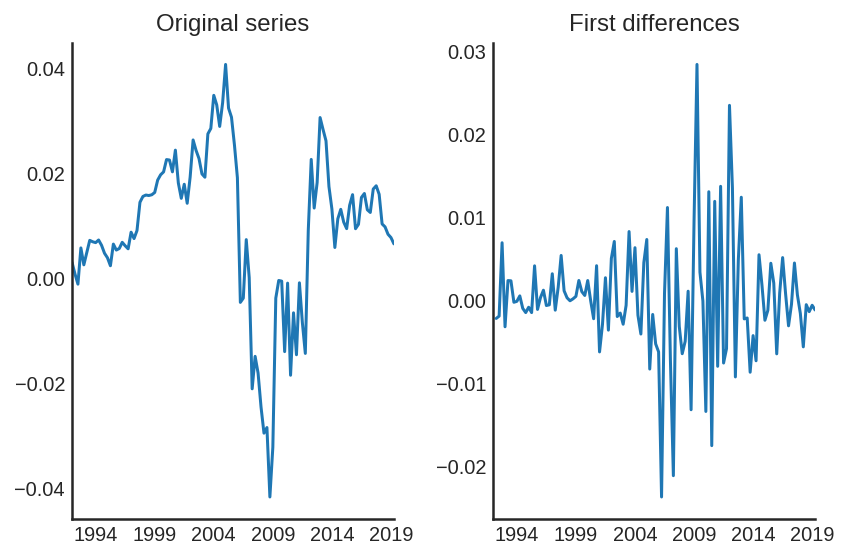

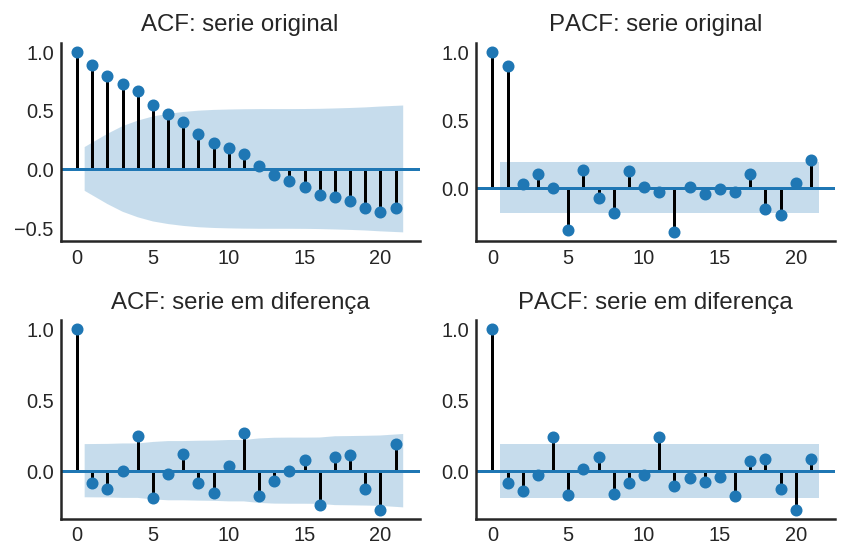


ZIVOT ANDREWS level series
        Zivot-Andrews Results        
Test Statistic                 -4.875
P-value                         0.043
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS First differences
        Zivot-Andrews Results        
Test Statistic                 -6.128
P-value                         0.001
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF level series
   Augmented Dickey-Fuller Results   
Test Statistic                 -2.672
P-value                

In [12]:
testes_raiz(df['Inflation'])

## Interest rate das hipotecas

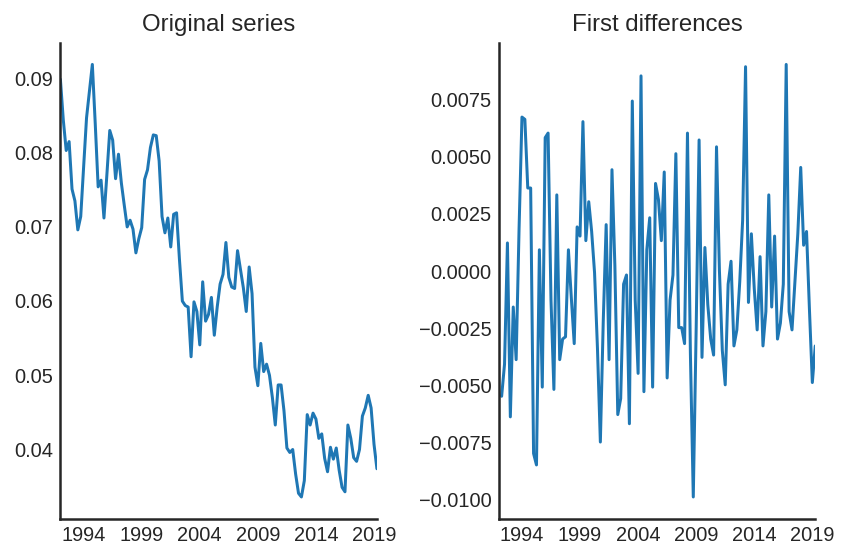

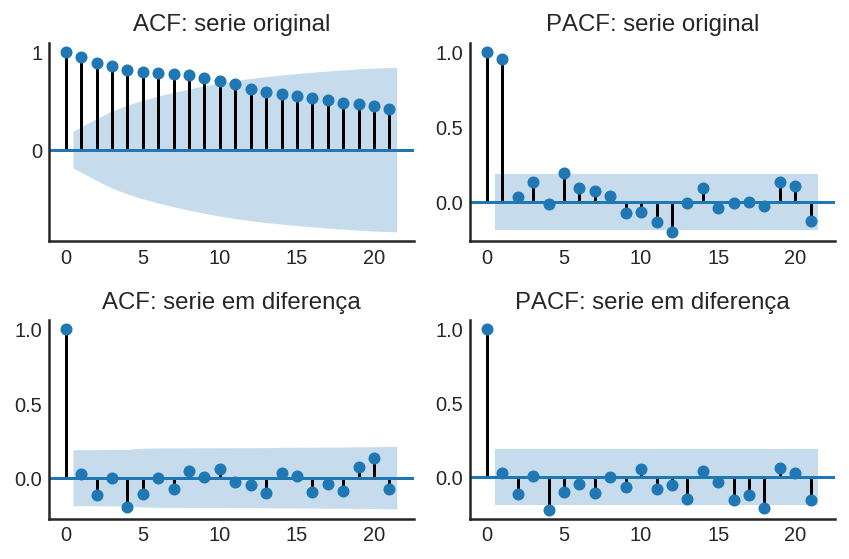


ZIVOT ANDREWS level series
        Zivot-Andrews Results        
Test Statistic                 -4.494
P-value                         0.215
Lags                                0
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -5.58 (1%), -5.07 (5%), -4.83 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS First differences
        Zivot-Andrews Results        
Test Statistic                 -8.144
P-value                         0.000
Lags                                1
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF level series
   Augmented Dickey-Fuller Results   
Test Statistic                 -3.638
P

In [13]:
testes_raiz(df['Interest rate'], original_trend='ct')

# Cointegração

## $g_Z$ e Own Interest rate

In [14]:
print("Ordem do VAR\n")

model = VAR(
    df[["gIh", 'Own Interest rate']],
)
print(model.select_order(maxlags=15, trend='ct').summary())

testes_coint(series=df[['gIh', 'Own Interest rate']], maxlag=9)

Ordem do VAR

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -14.82      -14.72   3.646e-07      -14.78
1       -16.32     -16.11*   8.137e-08      -16.24
2       -16.30      -15.97   8.372e-08      -16.17
3       -16.42      -15.99   7.401e-08      -16.25
4       -16.46      -15.92   7.109e-08      -16.24
5      -16.56*      -15.91  6.458e-08*     -16.30*
6       -16.49      -15.74   6.904e-08      -16.19
7       -16.45      -15.59   7.210e-08      -16.10
8       -16.39      -15.42   7.697e-08      -16.00
9       -16.39      -15.31   7.734e-08      -15.95
10      -16.32      -15.14   8.286e-08      -15.85
11      -16.31      -15.02   8.423e-08      -15.79
12      -16.53      -15.13   6.810e-08      -15.97
13      -16.47      -14.96   7.300e-08      -15.86
14      -16.45      -14.84   7.509e-08      -15.80
15      -16.40      -14.68   7.956e-08      -15.71
-----------------

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -9.990969
p-value: 0.000000
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Teste SEM constante
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          15.55          12.32
  1   2          2.633          4.130
-------------------------------------
Para lag = 5 e significância = 5.0%, Rank = 1

Teste COM constante

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          14.76          15.49
-------------------------------------
Para lag = 5 e significância = 5.0%, Rank = 0

Teste COM constante E tendência

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical v

## $g_Z$, Inflation e Interest rate

In [15]:
testes_coint(series=df[['gIh', 'Inflation', 'Interest rate']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.041700
p-value: 0.000118
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.098404
p-value: 0.000516
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -9.714353
p-value: 0.000000
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -10.819745
p-value: 0.000000
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Teste SEM constante
Johansen cointegration test using trace test statis

## $g_Z$ e Inflation

In [16]:
testes_coint(series=df[['gIh', 'Inflation']])


Testando para lag = 1 e trend = nc
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.108947
p-value: 0.000011
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = c
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.065403
p-value: 0.000125
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ct
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.035338
p-value: 0.000749
CONCLUSION: REJECT null Hypothesis: there IS cointegration


Testando para lag = 1 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -5.186856
p-value: 0.001679
CONCLUSION: REJECT null Hypothesis: there IS cointegration


TESTE DE JOHANSEN

Teste SEM constante
Johansen cointegration test using trace test statist

Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.794286
p-value: 0.361396
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


Testando para lag = 5 e trend = ctt
Null Hypothesis: there is NO cointegration
Alternative Hypothesis: there IS cointegration
t Statistic: -2.820231
p-value: 0.560204
CONCLUSION: FAIL to reject Null Hypothesis: there is NO cointegration


TESTE DE JOHANSEN

Teste SEM constante
Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          19.05          12.32
  1   2          5.184          4.130
-------------------------------------
Para lag = 5 e significância = 5.0%, Rank = 2

Teste COM constante

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   2          20.9

# VECM

VECM: $g_Z$, Inflation e Interest rate exógeno

## Ordem do modelo

In [17]:
from statsmodels.tsa.vector_ar.vecm import select_order

#det = 'cili'
#det = 'coli'
#det = 'colo'
det = 'cilo'
#det = 'ci'
#det = 'nc'
#det= 'co'

order_vec = select_order(
    df[[
        #"Inflation", 
        "Own Interest rate", 
        "gIh"
    ]], 
    #exog=df[["Interest rate"]],
    #seasons=4,
    maxlags=15, deterministic=det)

with open('../tabs/VECM_lag_order.tex','w') as fh:
    fh.write(order_vec.summary().as_latex_tabular(tile = "Selação ordem do VECM"))

order_vec.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

## Estimação

Det. terms outside the coint. relation & lagged endog. parameters for equation Own Interest rate
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
lin_trend            -1.633e-05   4.39e-05     -0.372      0.710      -0.000    6.97e-05
L1.Own Interest rate     0.0371      0.111      0.334      0.739      -0.181       0.255
L1.gIh                   0.0730      0.083      0.878      0.380      -0.090       0.236
L2.Own Interest rate    -0.0035      0.110     -0.031      0.975      -0.218       0.212
L2.gIh                   0.1112      0.082      1.362      0.173      -0.049       0.271
L3.Own Interest rate     0.0753      0.118      0.638      0.524      -0.156       0.307
L3.gIh                   0.1080      0.069      1.563      0.118      -0.027       0.243
L4.Own Interest rate     0.2657      0.119      2.237      0.025       0.033       0.498
L4.gIh       

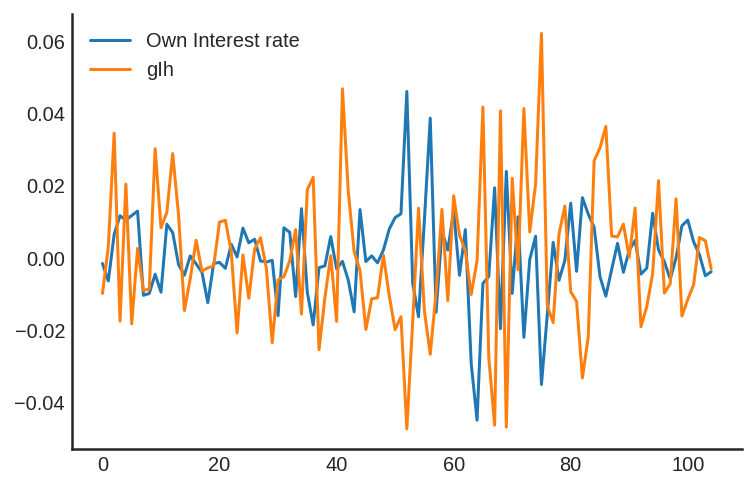

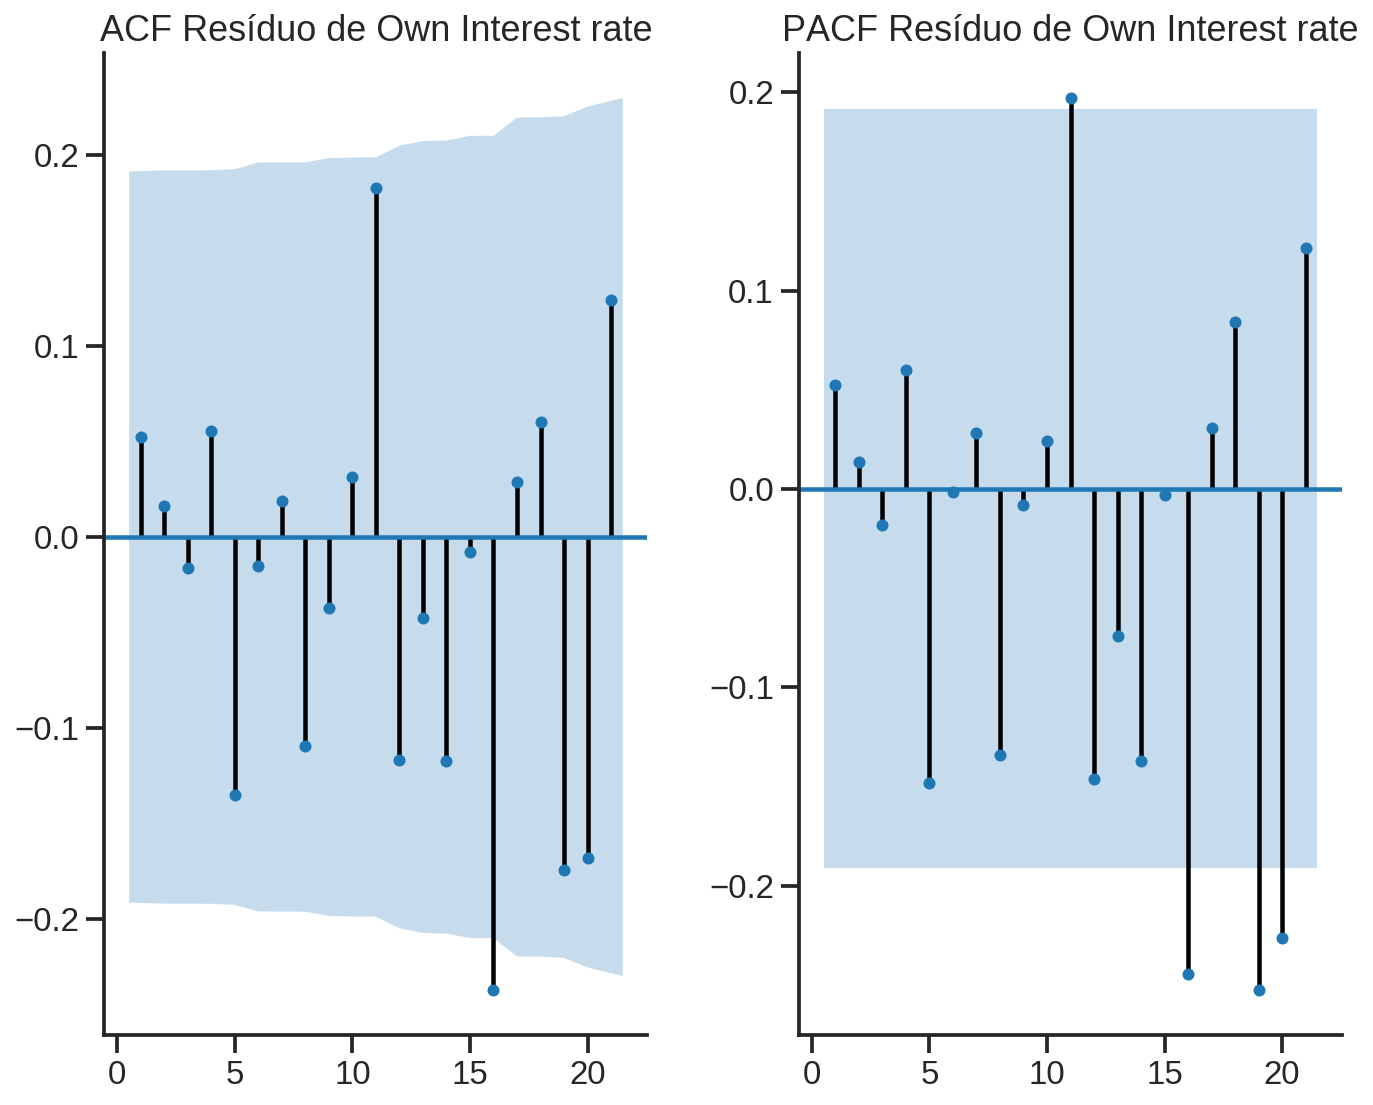

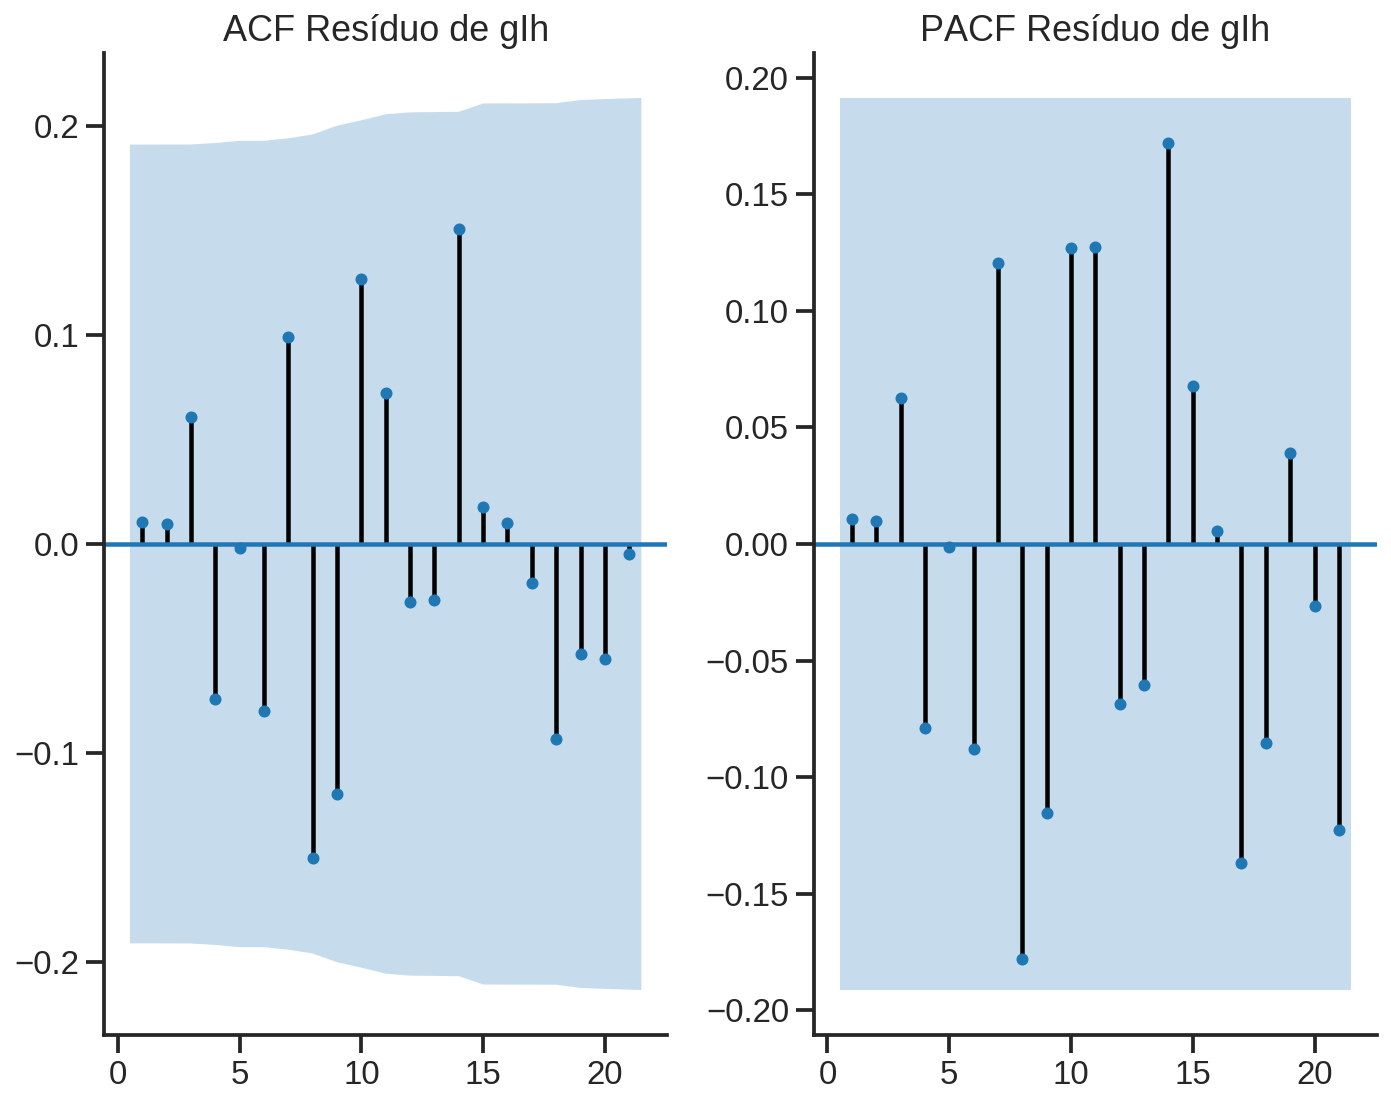

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         49.59          58.12   0.196 42
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         54.52          58.12   0.093 42
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  OWN INTEREST RATE . Considering a significance level of 5.0 %
p-value = 0.91374515789253
Reject H0 on lag  1 ?  False 

p-value = 0.9890

In [18]:
model = VECM(
    endog = df[[
        #"Inflation", 
        "Own Interest rate", 
        "gIh"
    ]], 
    #exog=df[["Interest rate"]],
    #k_ar_diff=0,
    #k_ar_diff=1,
    #k_ar_diff=2,
    #k_ar_diff=3,
    k_ar_diff=4,
    #k_ar_diff=5,
    #k_ar_diff=6,
    #k_ar_diff=7,
    #k_ar_diff=8,
    deterministic=det, 
    #seasons=4,
)
results = model.fit()

with open('../tabs/VECM_ajuste.tex','w') as fh:
    fh.write(results.summary().as_latex())

print(results.summary())

print(60*"=")
print("\nPÓS ESTIMAÇÂO\n")
residuals = analise_residuos(results=results)
print(60*"=")

## Função Impulse resposta ortogonalizada

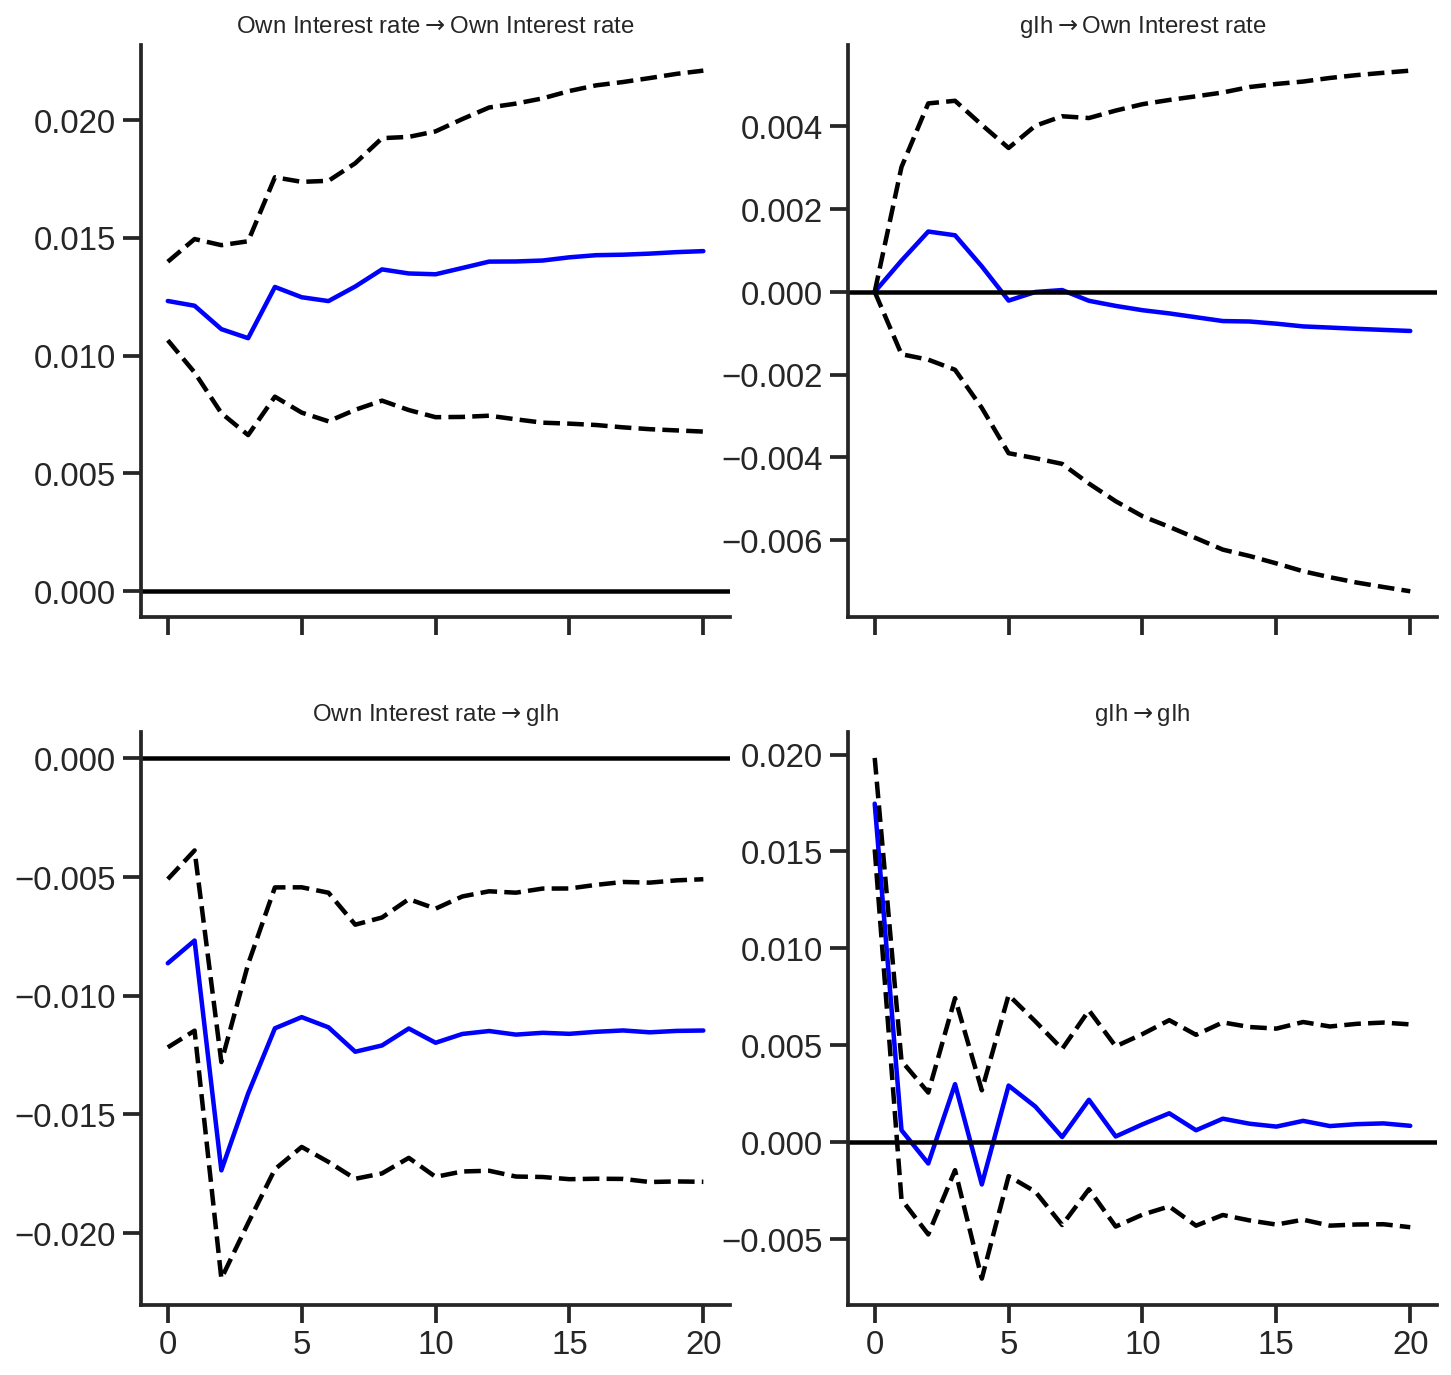

In [19]:
    p = results.irf(20).plot(orth=True)
    p.suptitle("")
    sns.despine()
    plt.show()
    p.savefig("../figs/Impulse_VECMOrth.eps", dpi = 600, bbox_inches = 'tight',
        pad_inches = 0.2, transparent = True,)

## Função Impulse resposta não-ortogonalizada

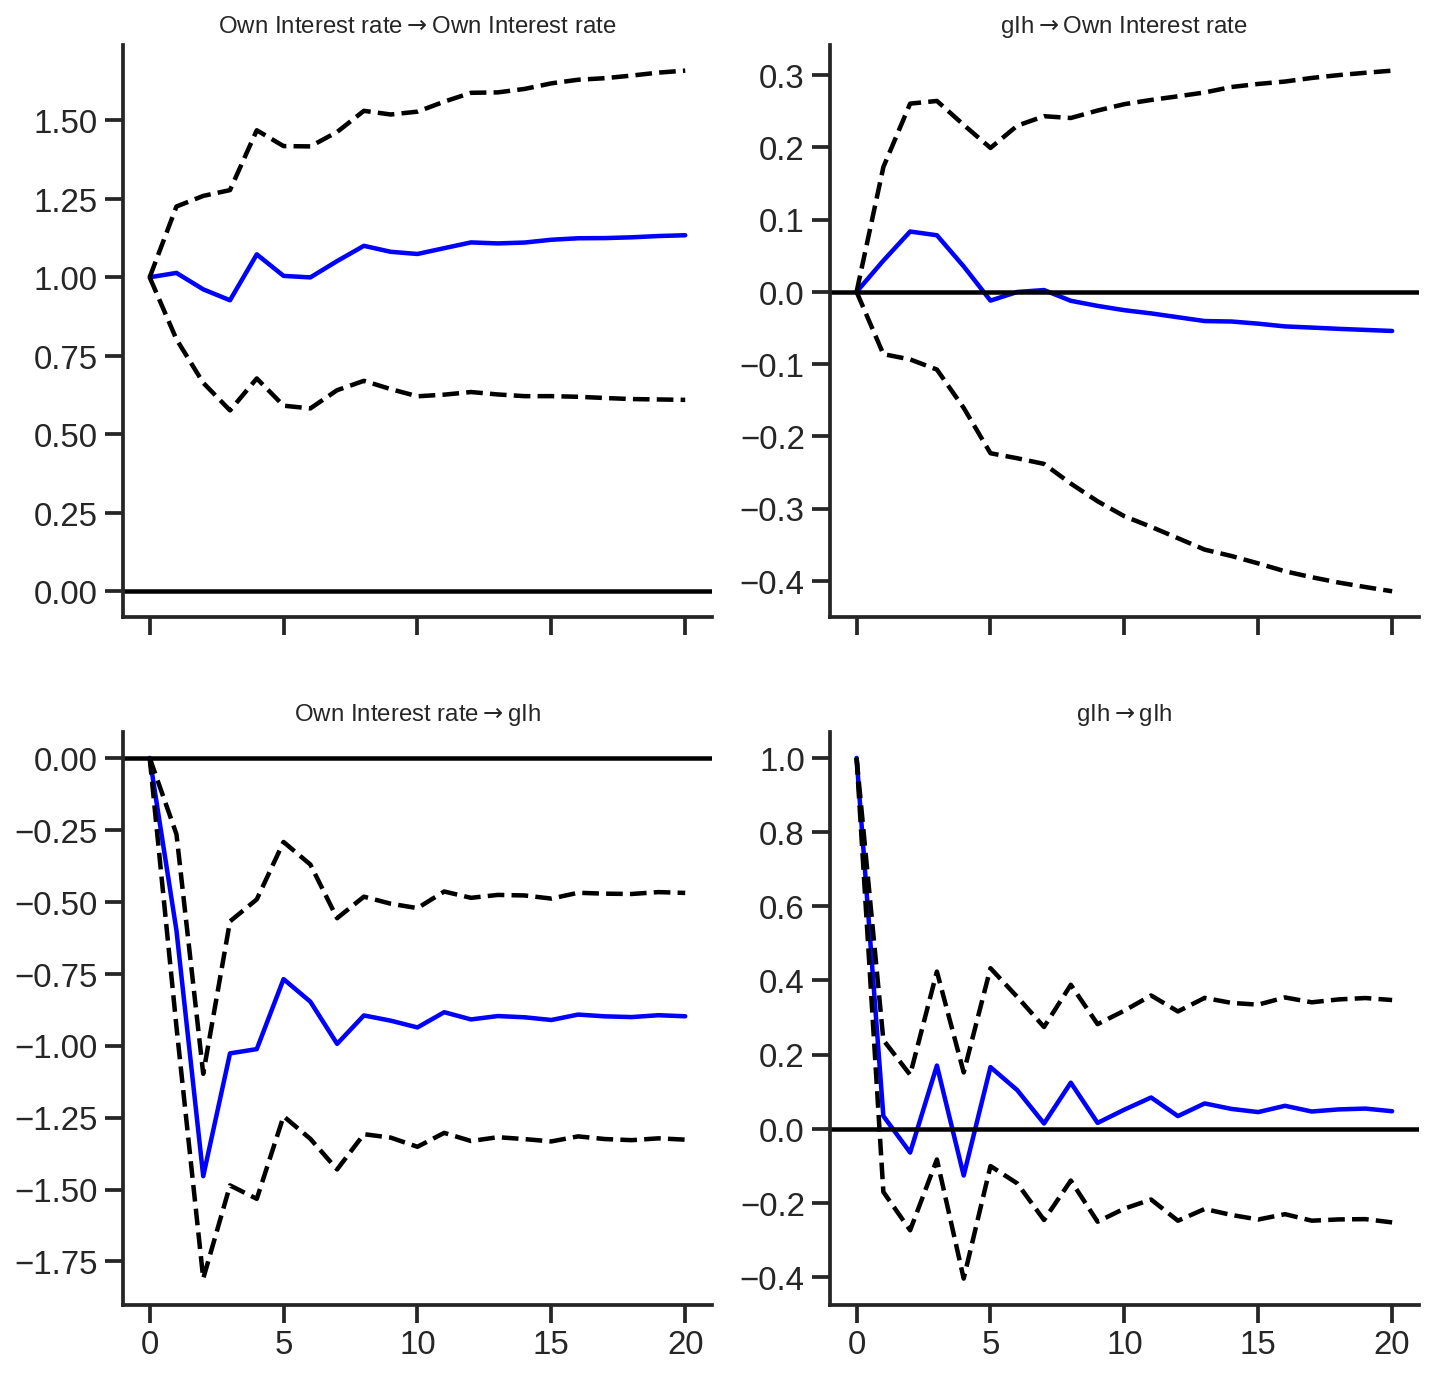

In [20]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("../figs/Impulse_VECM.eps", dpi = 600, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Teste de causalidade de granger

In [21]:
series = residuals.columns
print(results.test_granger_causality(causing=series[0], caused=series[1]).summary())
print(results.test_inst_causality(causing=series[0]).summary())

Granger causality F-test. H_0: Own Interest rate does not Granger-cause gIh. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         12.30          2.264   0.000 (5, 180)
----------------------------------------------
Instantaneous causality Wald-test. H_0: Own Interest rate does not instantaneously cause gIh. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         15.37          3.841   0.000  1
----------------------------------------


## Inspeção gráfica dos resíduos

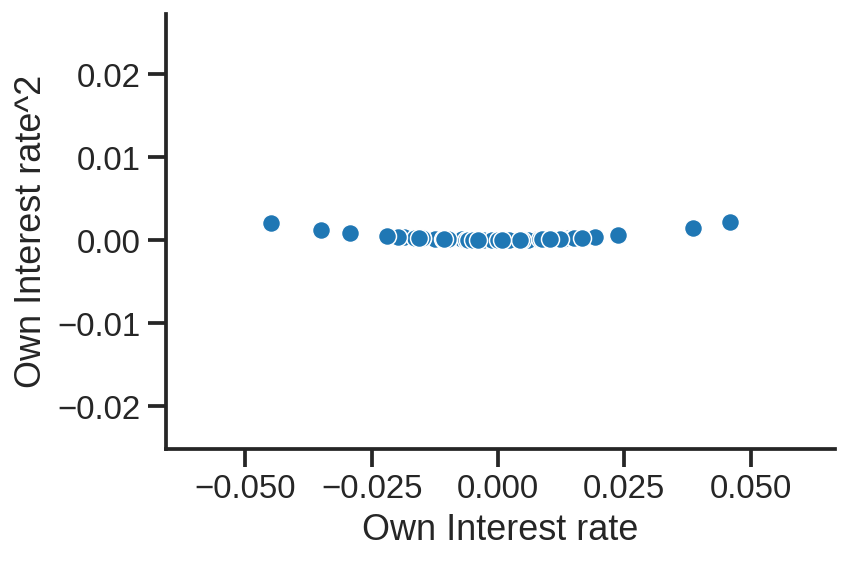

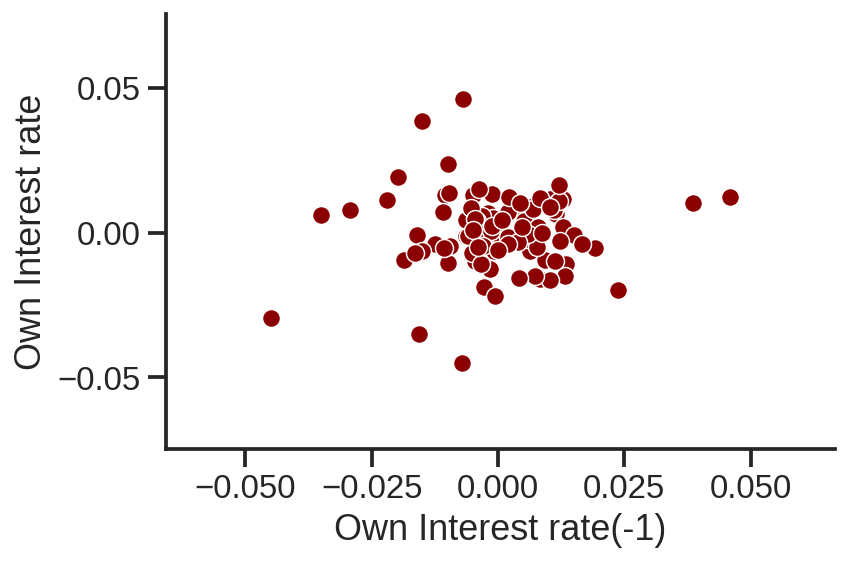

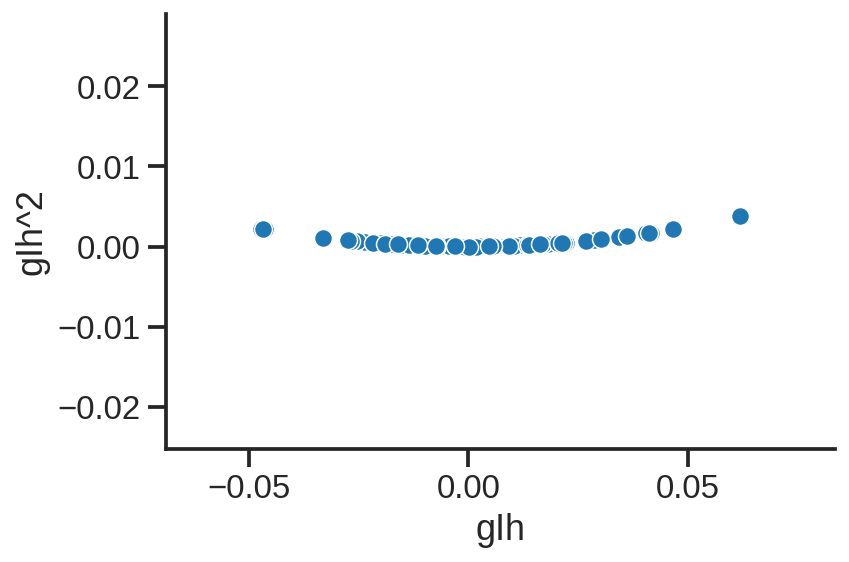

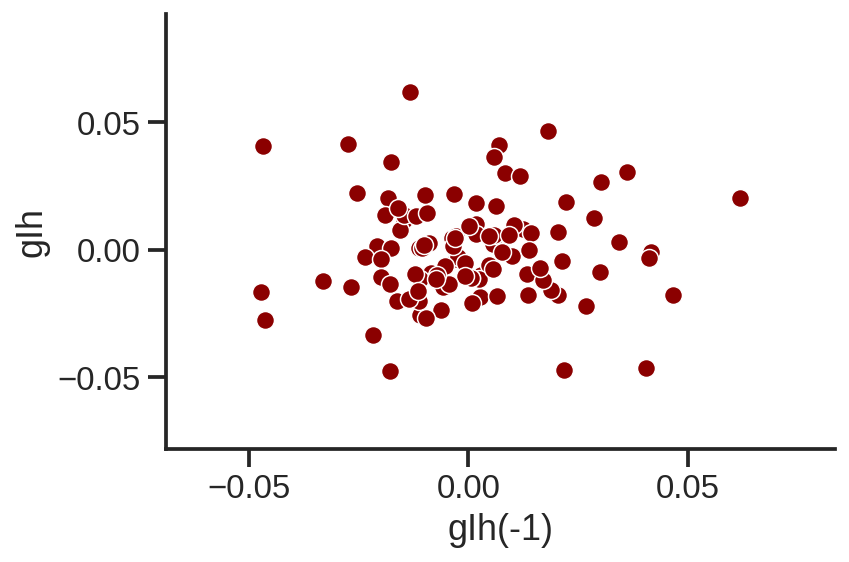

In [22]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    plt.ylabel(f"{serie}^2")
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

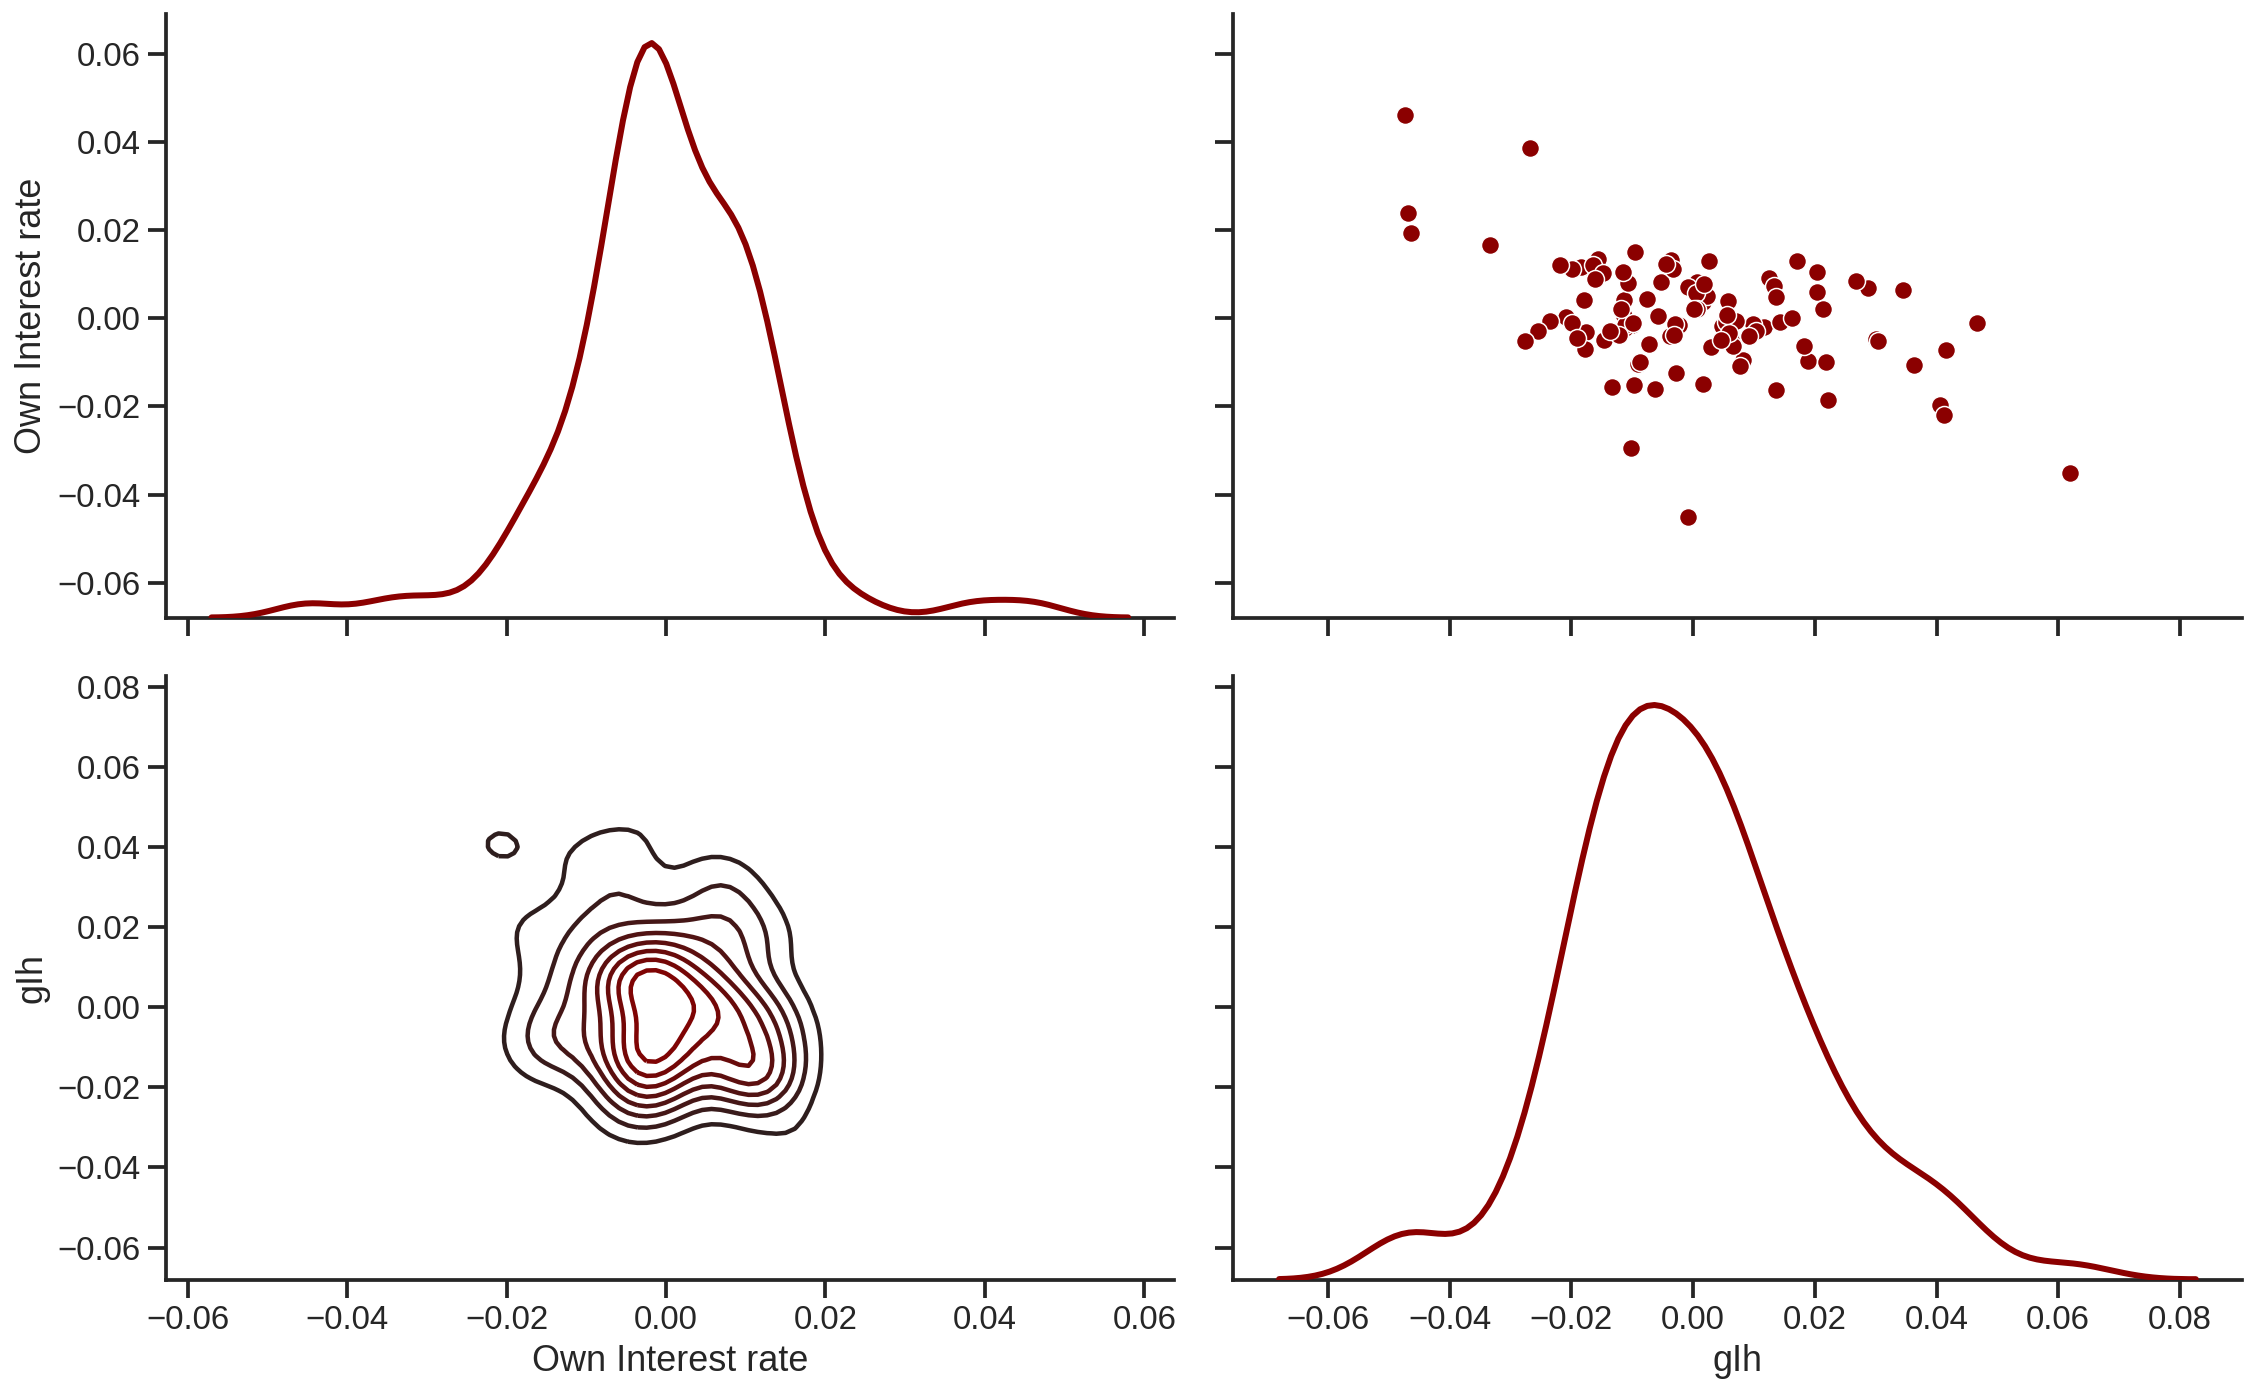

In [23]:
sns.set_context('talk')
g = sns.PairGrid(residuals, diag_sharey=False, height = 5, aspect=(8/5))
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.tight_layout()
plt.show()
g.savefig("../figs/Residuals_4VECM.eps", dpi = 600, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

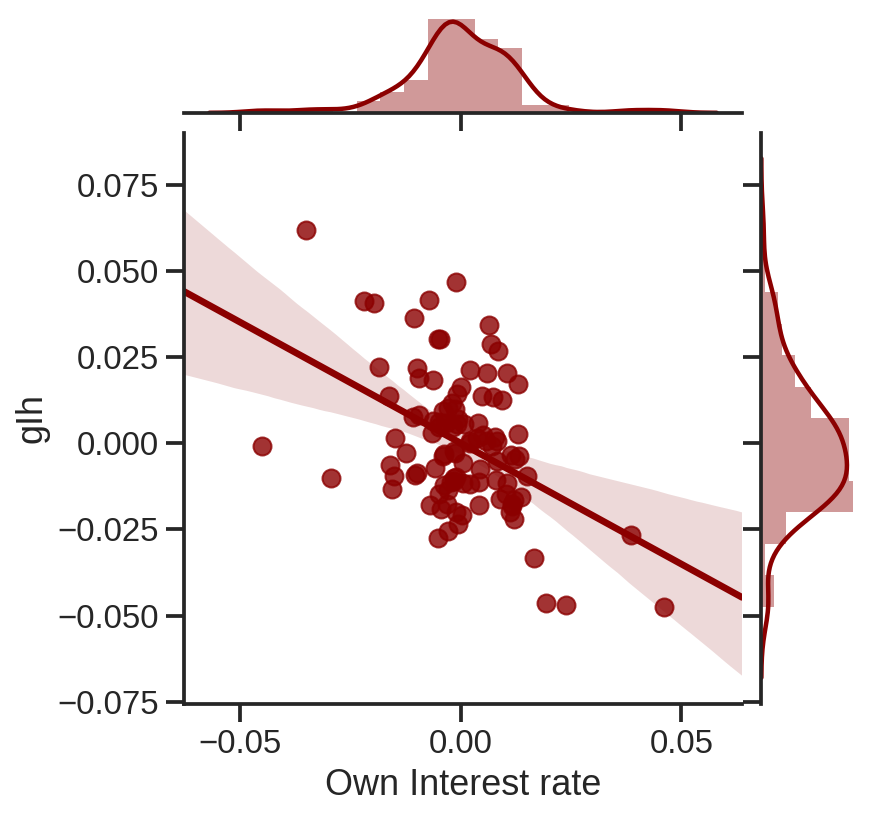

In [24]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

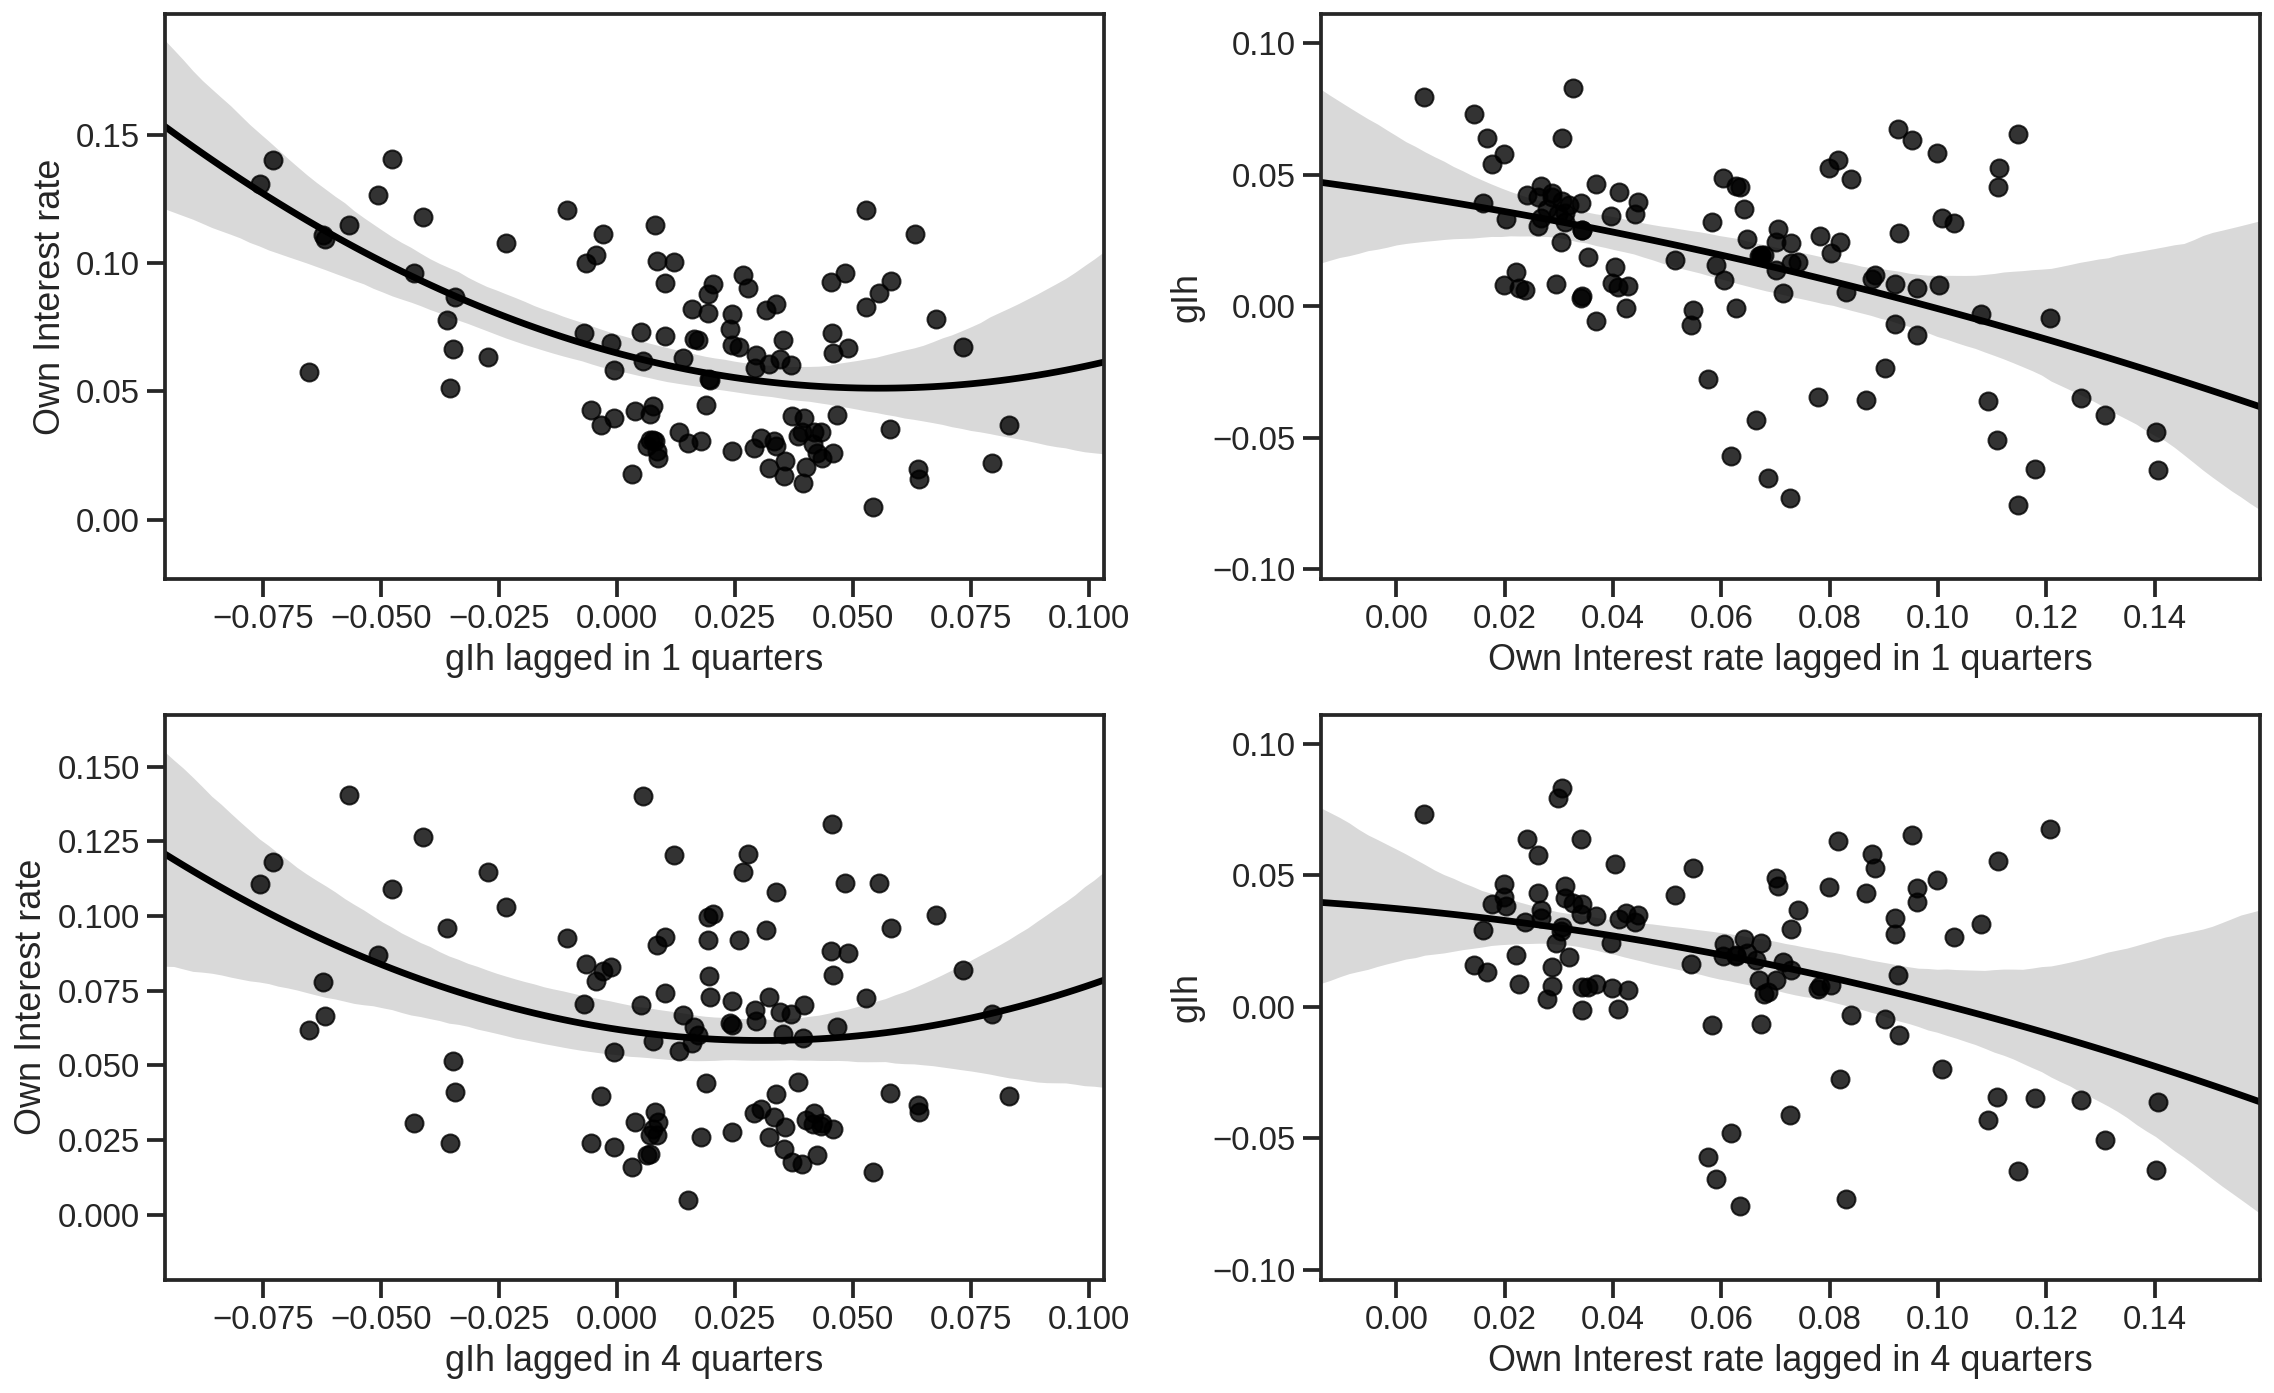

In [25]:
fig = plot_lags(results=results, trimestres=[1,4])
fig.savefig("../figs/VEC_Defasagens.pdf", dpi = 600, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## FEVD

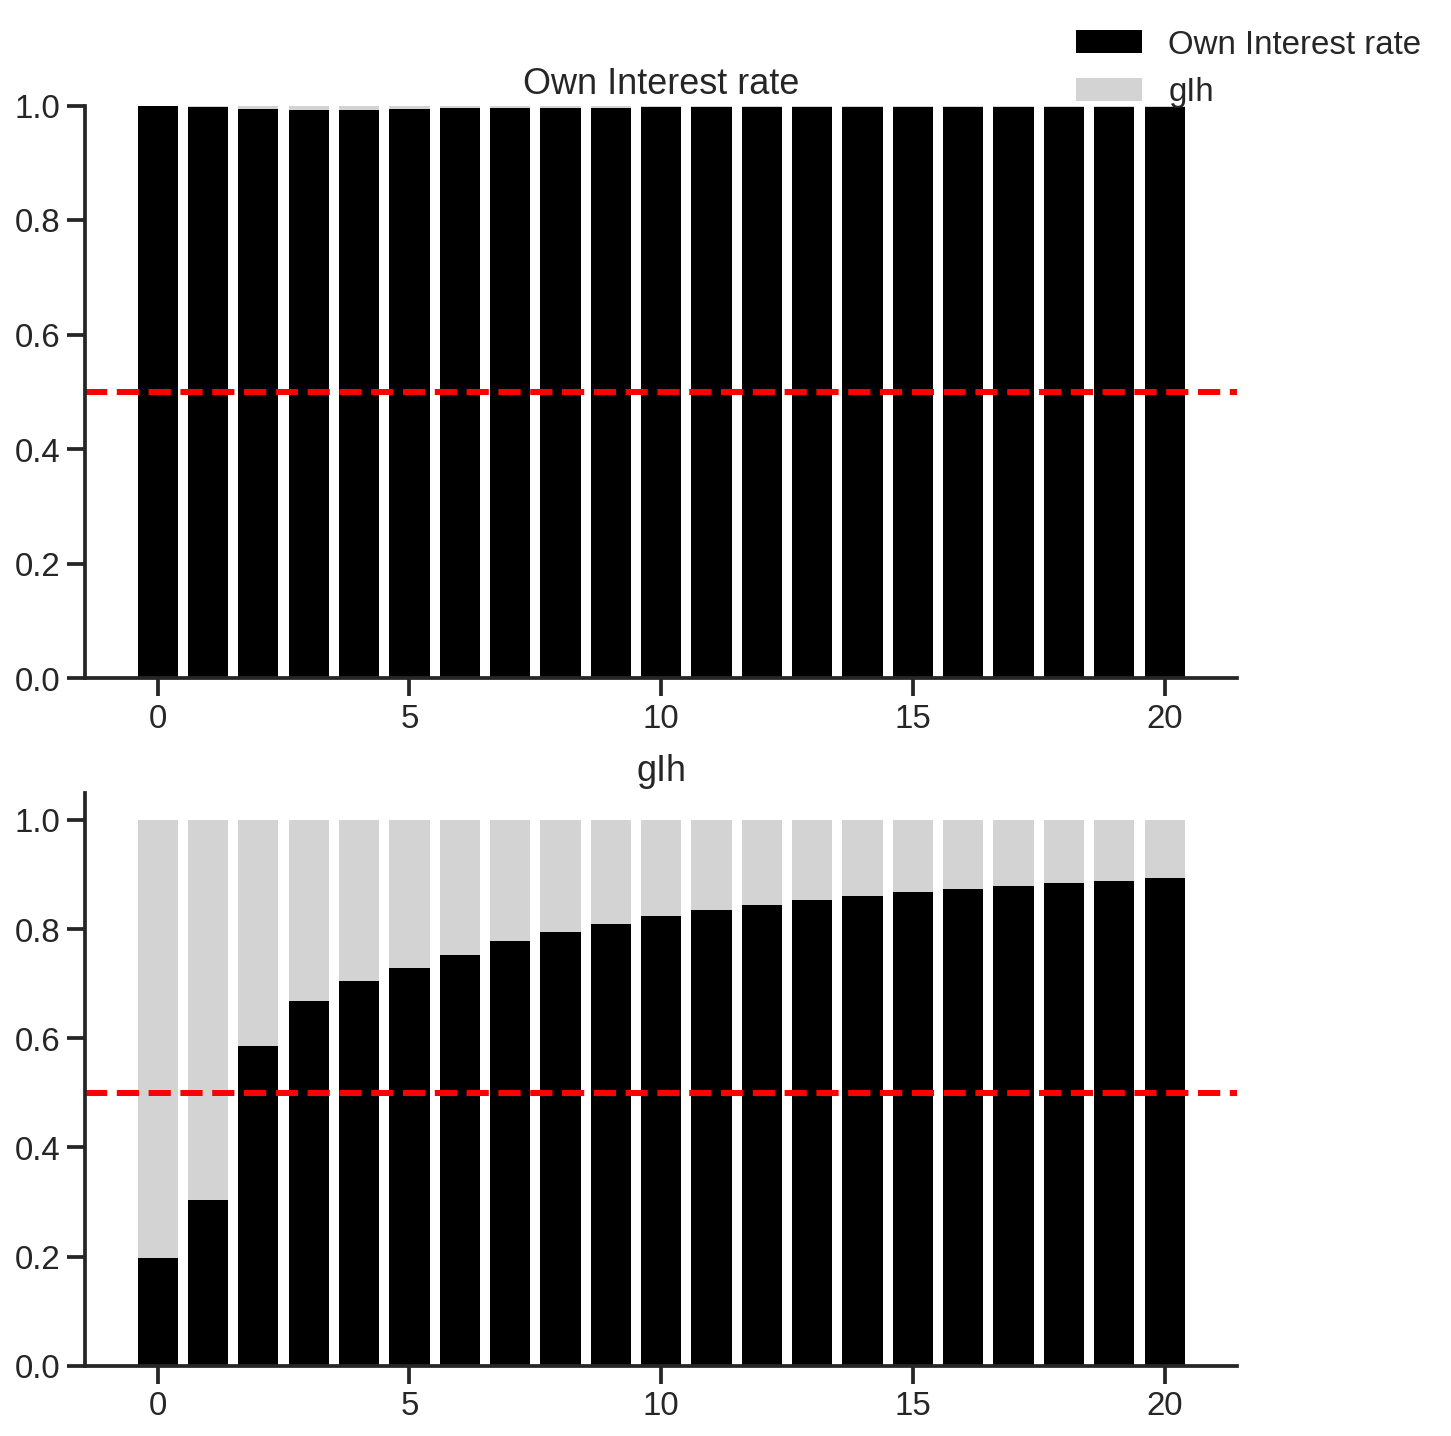

In [26]:
fig = FEVD(results, periods=21).plot()
fig.savefig("../figs/FEVD_VECMpython_TxPropria.eps", dpi = 600, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

In [27]:
%%R -o fevd_gIh
library(tsDyn)
library(readr)
df <- read.csv("../data/Data_yeojohnson.csv", encoding="UTF-8")
#df <- df[,c(4:7)]
names(df) <- c("Time","Infla", "gIh", "Own", "Interest rate")
df <- na.omit(df[,c("Time","Infla", "gIh", "Own", "Interest rate")])
df <- ts(data = df, start = c(1992,03), frequency = 4)
model <- tsDyn::VECM(data = df[,c("Own","gIh")], lag = 4, r = 1, estim = "ML", LRinclude="both", include="none")
fevd_gIh = data.frame(tsDyn::fevd(model, 20)$gIh)

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff



In [28]:
%%R -o fevd_tx
fevd_tx = data.frame(tsDyn::fevd(model, 20)$Own)

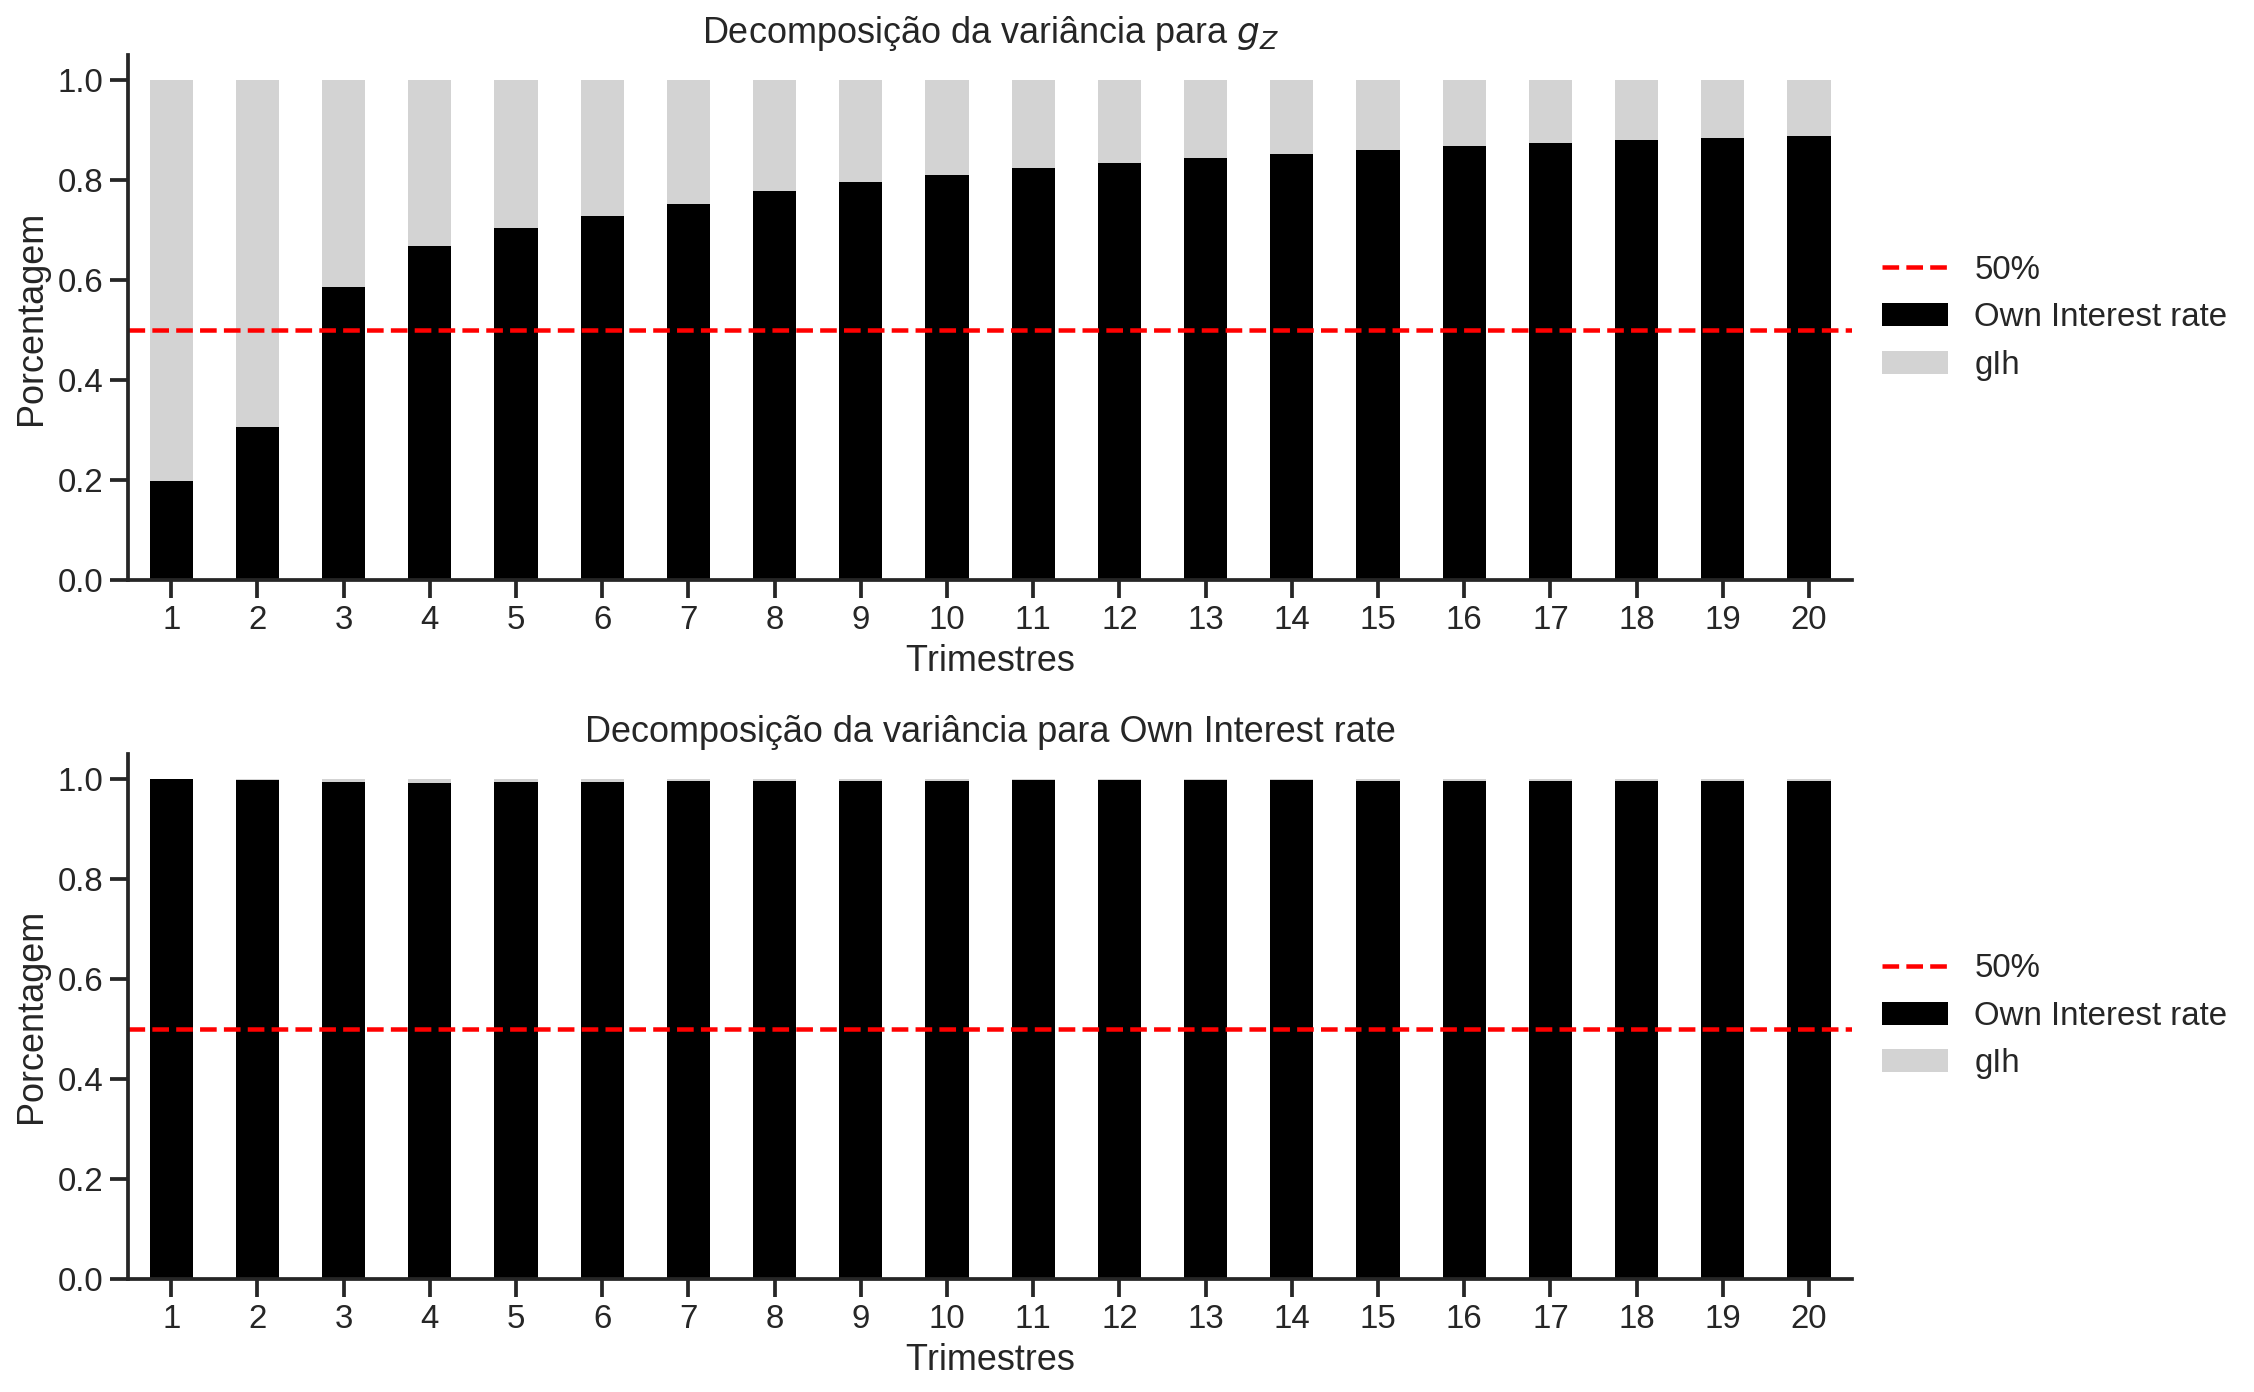

In [29]:
sns.set_context('talk')
fig, ax = plt.subplots(2,1, figsize = (16,10))

fevd_gIh.plot(
    ax=ax[0], 
    title = "Decomposição da variância para $g_Z$", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True
)
ax[0].set_xlabel('Trimestres')
ax[0].set_ylabel('Porcentagem')
ax[0].axhline(y=0.5, color = 'red', ls = '--')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Own Interest rate", "gIh"))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)


fevd_tx.plot(
    ax=ax[1], 
    title = "Decomposição da variância para Own Interest rate", 
    color = ("black", "lightgray"), 
    kind = 'bar', stacked = True,
)
ax[1].axhline(y=0.5, color = 'red', ls = '--')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = ("50%", "Own Interest rate", "gIh"))
ax[1].set_xlabel('Trimestres')
ax[1].set_ylabel('Porcentagem')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

sns.despine()
plt.tight_layout()
plt.show()
fig.savefig("../figs/FEVD_VECM.eps", dpi = 600, bbox_inches = 'tight',
    pad_inches = 0.2, transparent = True,)

## Estacionariedade dos resíduos

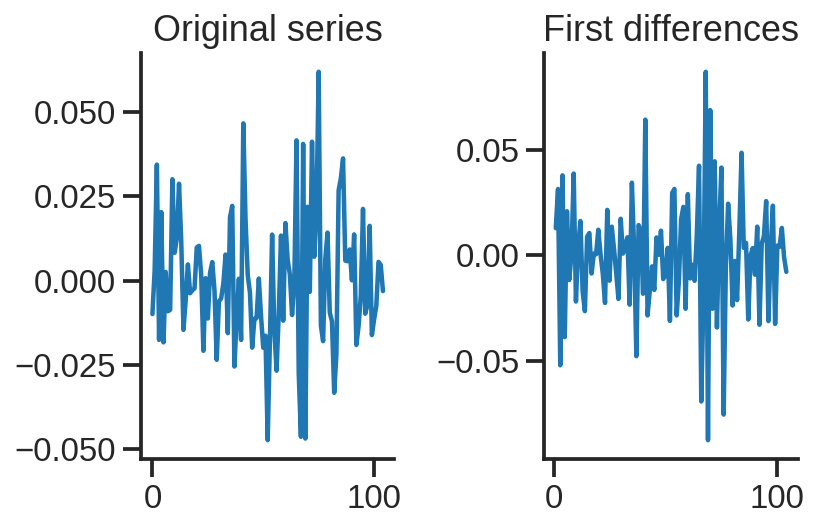

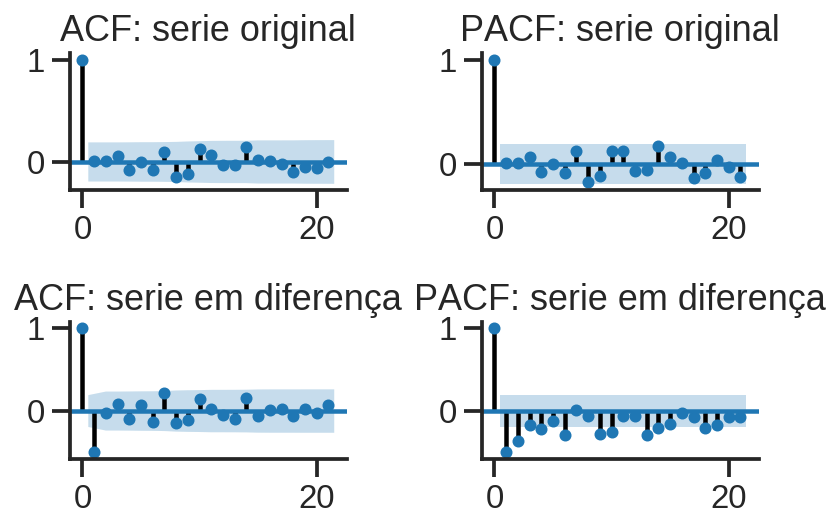


ZIVOT ANDREWS level series
        Zivot-Andrews Results        
Test Statistic                -10.605
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS First differences
        Zivot-Andrews Results        
Test Statistic                 -6.307
P-value                         0.001
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF level series
   Augmented Dickey-Fuller Results   
Test Statistic                -10.006
P-value                

In [30]:
testes_raiz(residuals['gIh'])

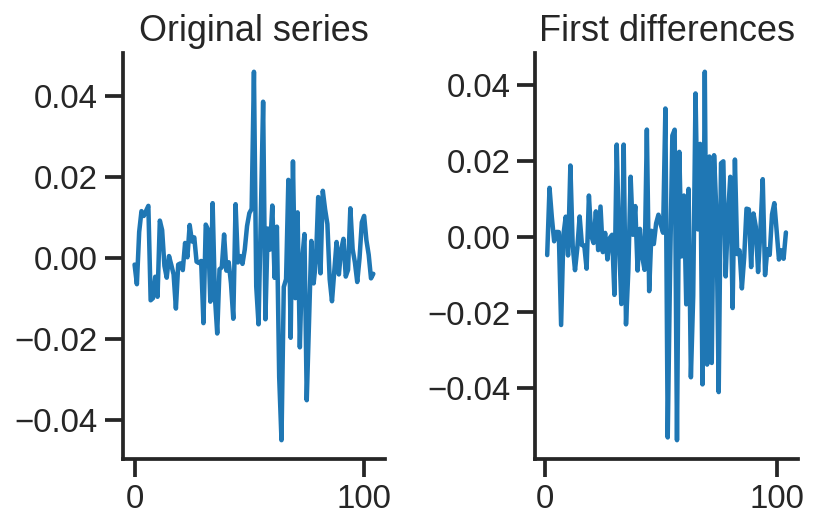

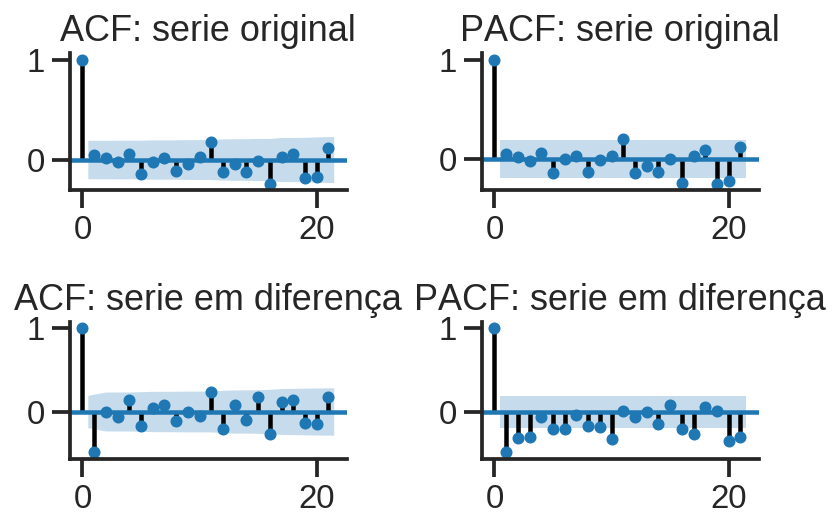


ZIVOT ANDREWS level series
        Zivot-Andrews Results        
Test Statistic                -10.038
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ZIVOT ANDREWS First differences
        Zivot-Andrews Results        
Test Statistic                 -6.783
P-value                         0.000
Lags                                9
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary. 


ADF level series
   Augmented Dickey-Fuller Results   
Test Statistic                 -9.582
P-value                

In [31]:
testes_raiz(residuals['Own Interest rate'])

# VAR

**Dúvida:** Variável exógena do VAR deve ser estacionária também?

## Ordem do modelo

In [32]:
model = VAR(
    df[["d_Own Interest rate", 'd_gIh']],
)
print(model.select_order(maxlags=15, trend='ct').summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -15.74      -15.63   1.465e-07      -15.69
1       -15.90      -15.68   1.245e-07      -15.81
2       -16.24     -15.91*   8.882e-08      -16.11
3       -16.20      -15.77   9.235e-08      -16.02
4       -16.33      -15.79  8.082e-08*     -16.12*
5       -16.33      -15.68   8.137e-08      -16.07
6       -16.30      -15.55   8.347e-08      -16.00
7       -16.24      -15.38   8.906e-08      -15.89
8       -16.27      -15.30   8.658e-08      -15.88
9       -16.23      -15.16   9.039e-08      -15.80
10      -16.24      -15.06   9.023e-08      -15.76
11     -16.35*      -15.06   8.134e-08      -15.83
12      -16.32      -14.92   8.405e-08      -15.76
13      -16.30      -14.79   8.641e-08      -15.69
14      -16.22      -14.61   9.408e-08      -15.57
15      -16.16      -14.44   1.016e-07      -15.46
-------------------------------

Adotando o BIC como critério de seleção dada a parciomônia, estima-se uma VAR de ordem 5.

## Estimação

In [33]:
results = model.fit(maxlags=4)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           seg, 23, mar, 2020
Time:                     14:16:45
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -15.9194
Nobs:                     106.000    HQIC:                  -16.1883
Log likelihood:           584.883    FPE:                7.76668e-08
AIC:                     -16.3717    Det(Omega_mle):     6.59860e-08
--------------------------------------------------------------------
Results for equation d_Own Interest rate
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -0.000227         0.001275           -0.178           0.859
L1.d_Own Interest rate         0.025830         0.107958            0.239           0.811
L1.d_gIh  

## Pós-estimação

### Autocorrelação dos resíduos 

**OBS:** série consigo mesma na diagonal principal.

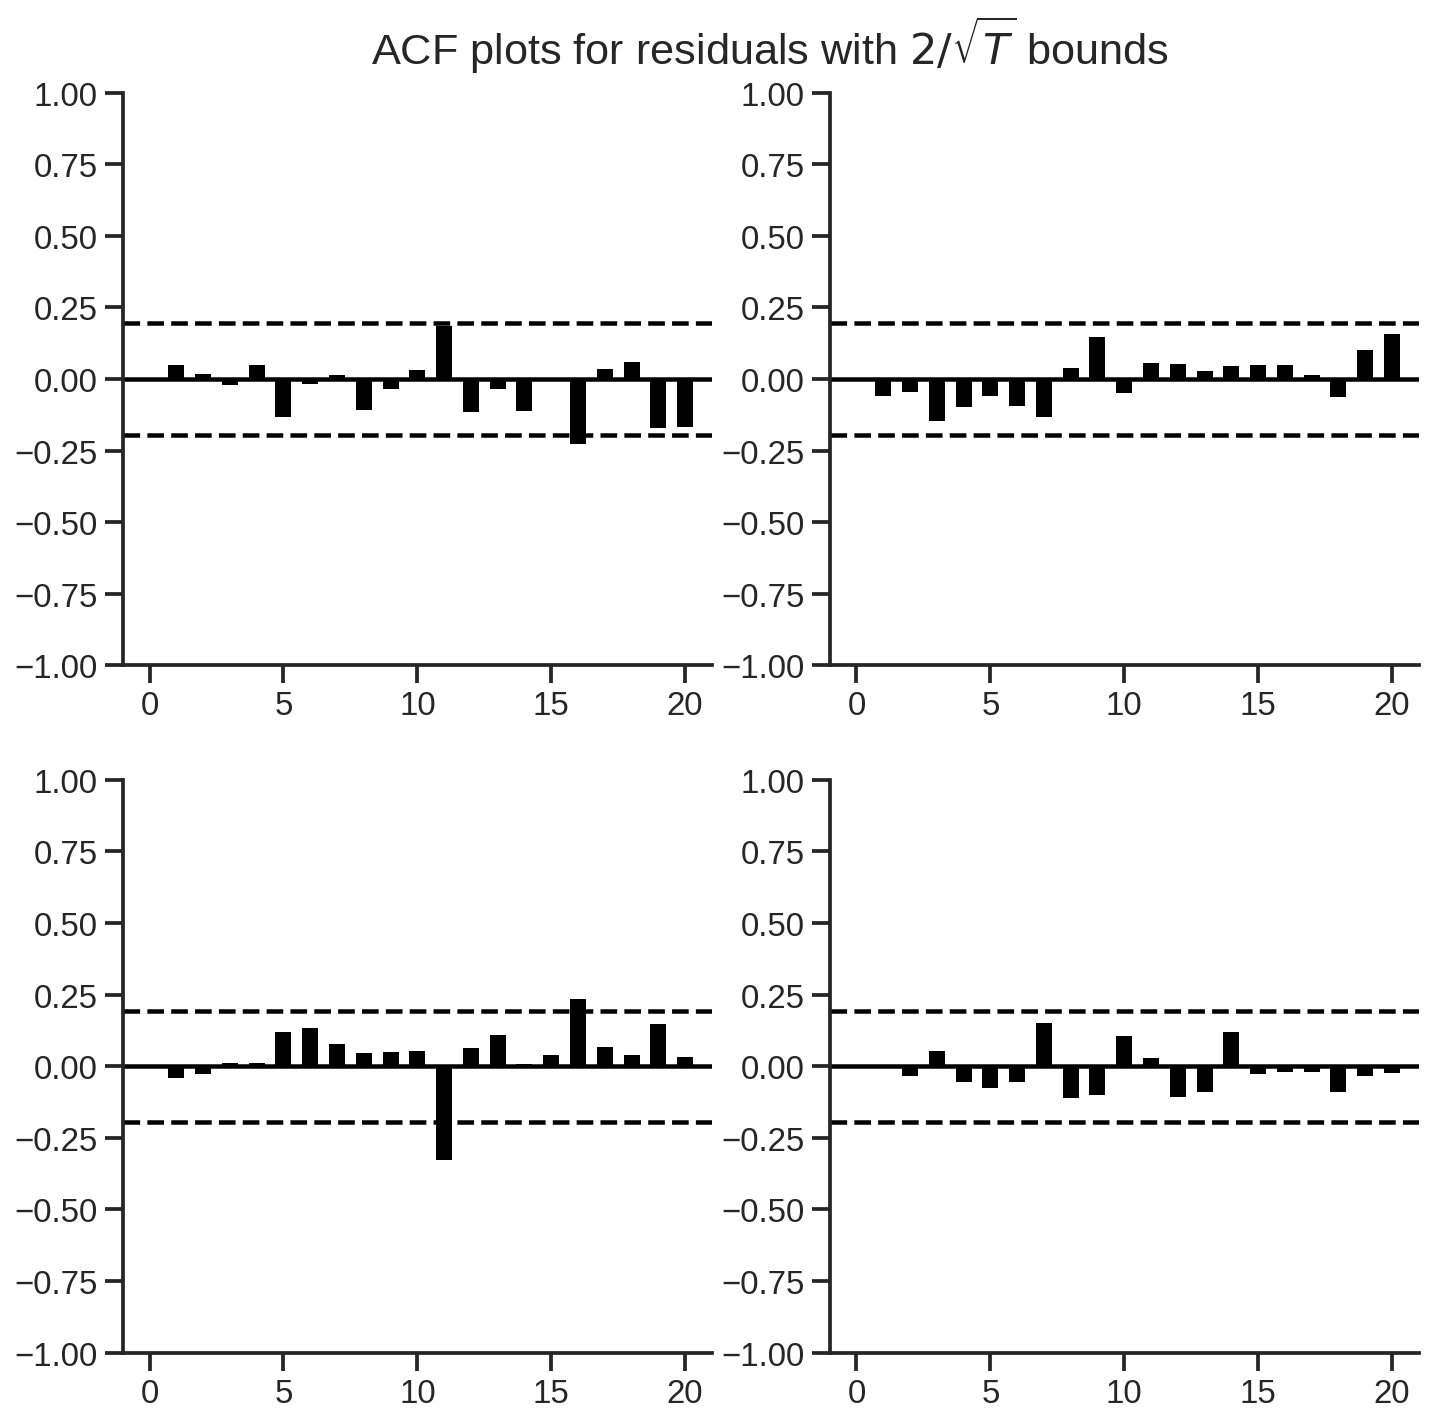

In [34]:
results.plot_acorr(nlags = 20)
sns.despine()
plt.show()

**Conclusão:** Pela inspeção gráfica, o modelo não apresenta autocorrelação serial dos resíduos.

### Estabilidade

In [35]:
print("Estável:", results.is_stable(verbose=True))

Eigenvalues of VAR(1) rep
0.6027050839504101
0.7013862332963364
0.7013862332963364
0.7440788873230659
0.7440788873230659
0.6608539404052278
0.8122189154603079
0.8122189154603079
Estável: True


**OBS:** Apesar de estar escrito VAR(1), os resultados acima correspondem ao VAR(p)

## Inspeção dos resíduos

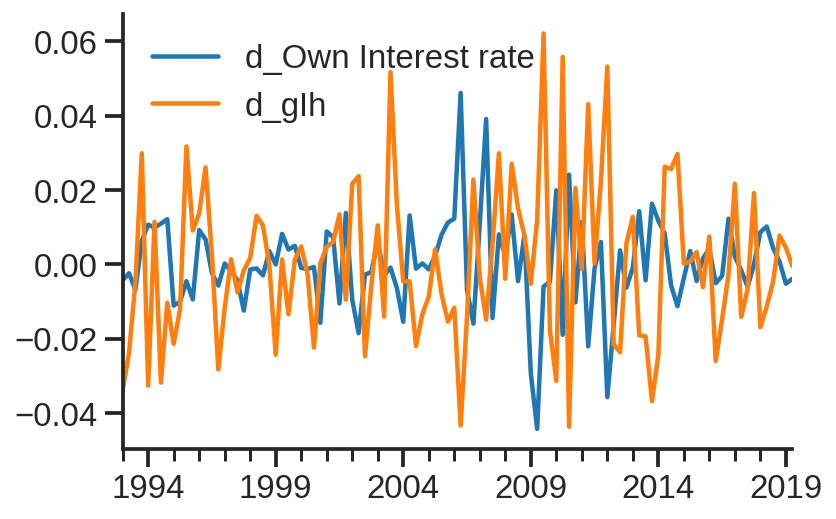

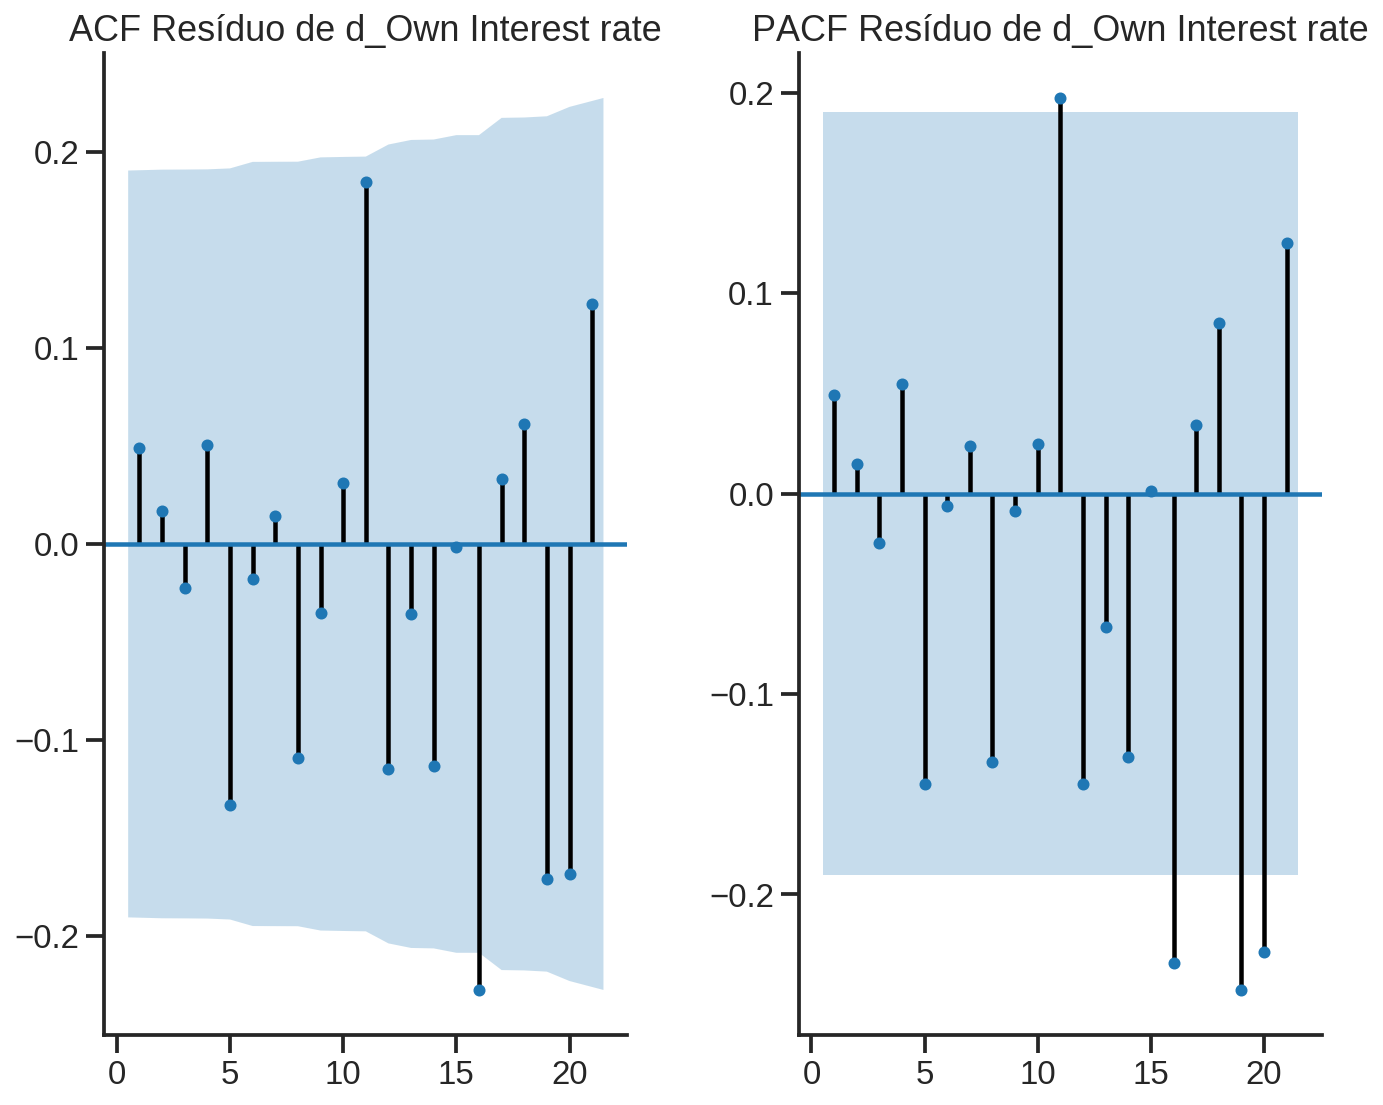

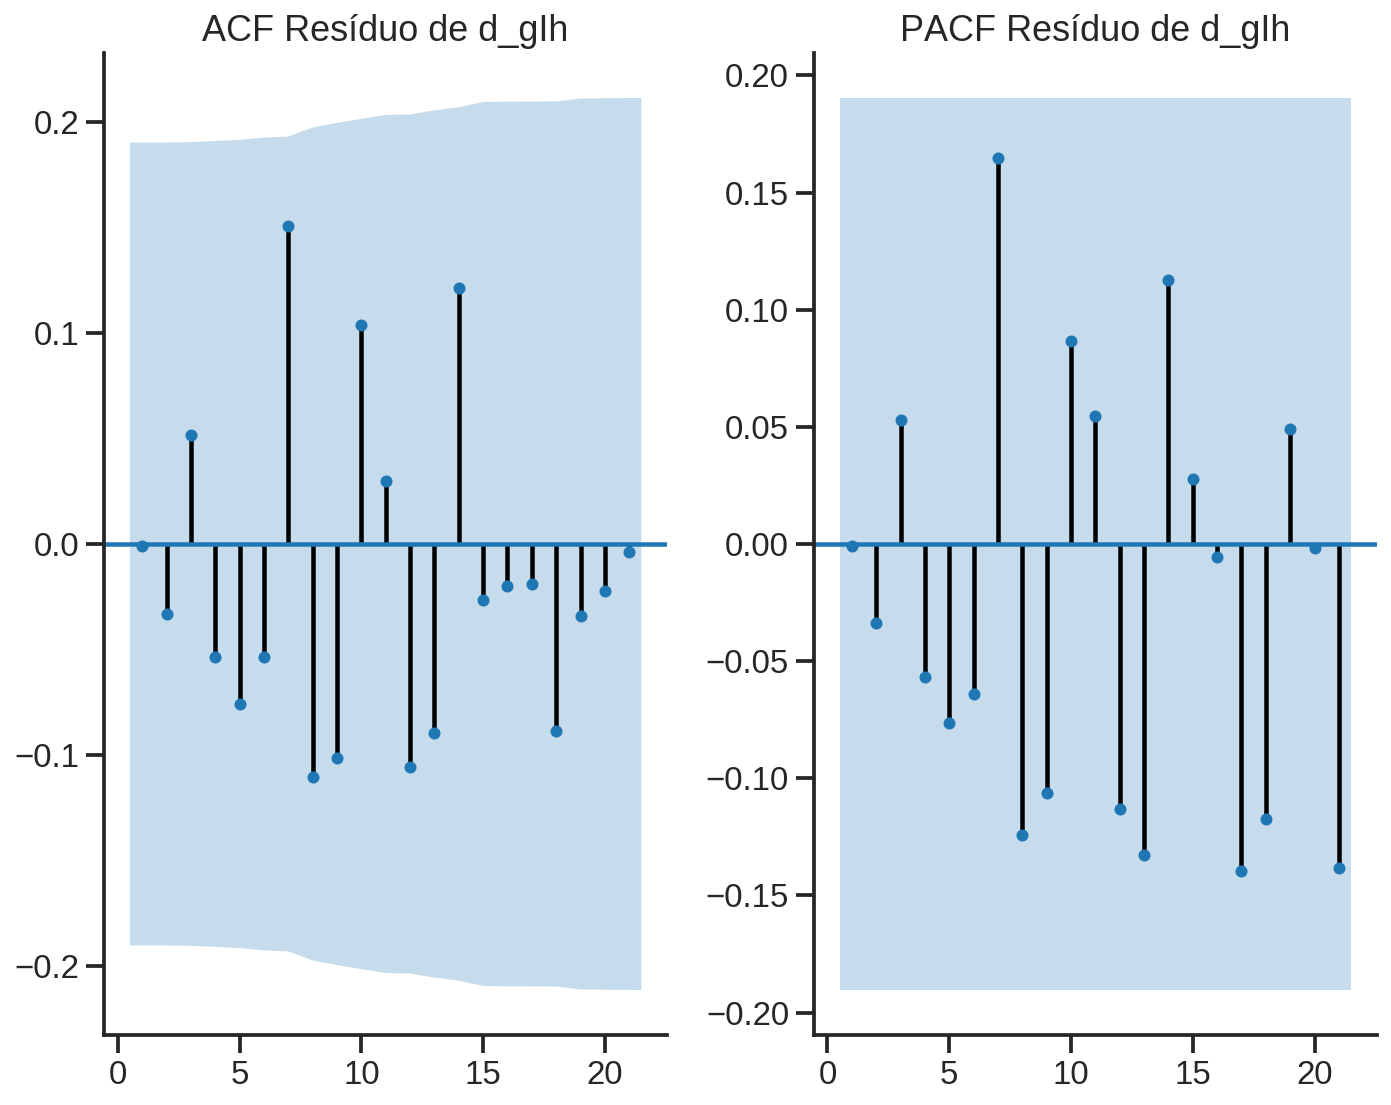

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         50.84          60.48   0.222 44
----------------------------------------

AUTOCORRELAÇÃO RESIDUAL: PORTMANTEAU AJUSTADO

Adjusted Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 15 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         55.43          60.48   0.116 44
----------------------------------------

LJUNGBOX

H0: autocorrelations up to lag k equal zero
H1: autocorrelations up to lag k not zero
Box-Pierce:  False
Testing for  D_OWN INTEREST RATE . Considering a significance level of 5.0 %
p-value = 0.993577432207184
Reject H0 on lag  1 ?  False 

p-value = 0.9

In [36]:
residuals = analise_residuos(results=results)

## Inspeção gráfica dos resíduos

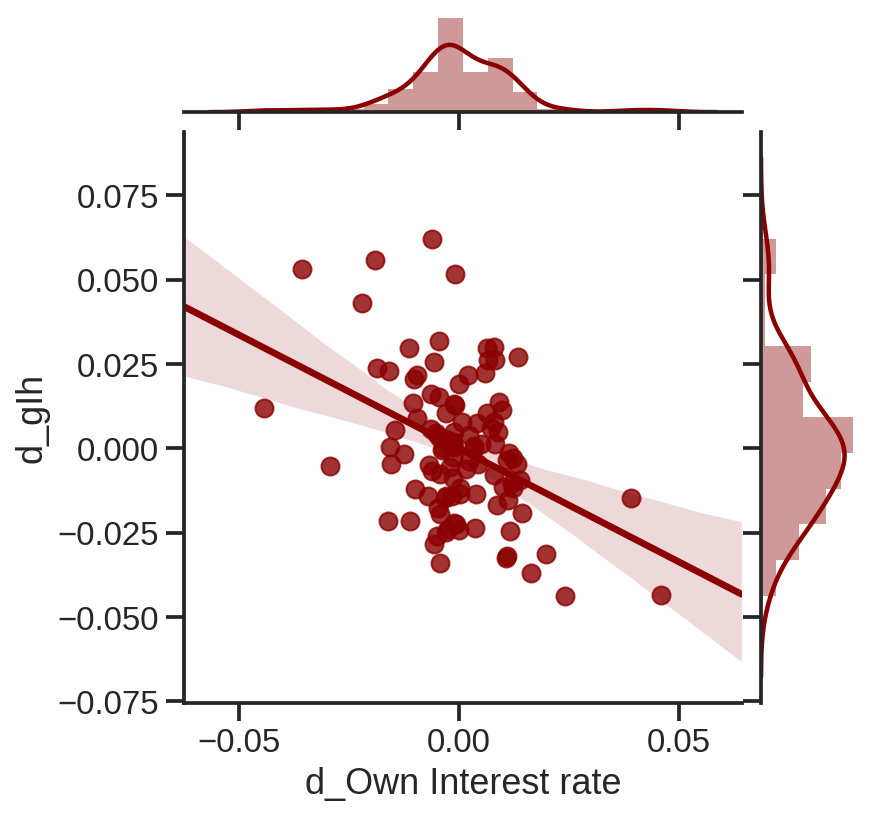

In [37]:
series = results.names
sns.set_context('talk')
ax = sns.jointplot(
    x = series[0], 
    y = series[1], 
    data = residuals, color = 'darkred', kind="reg", 
)
plt.show()

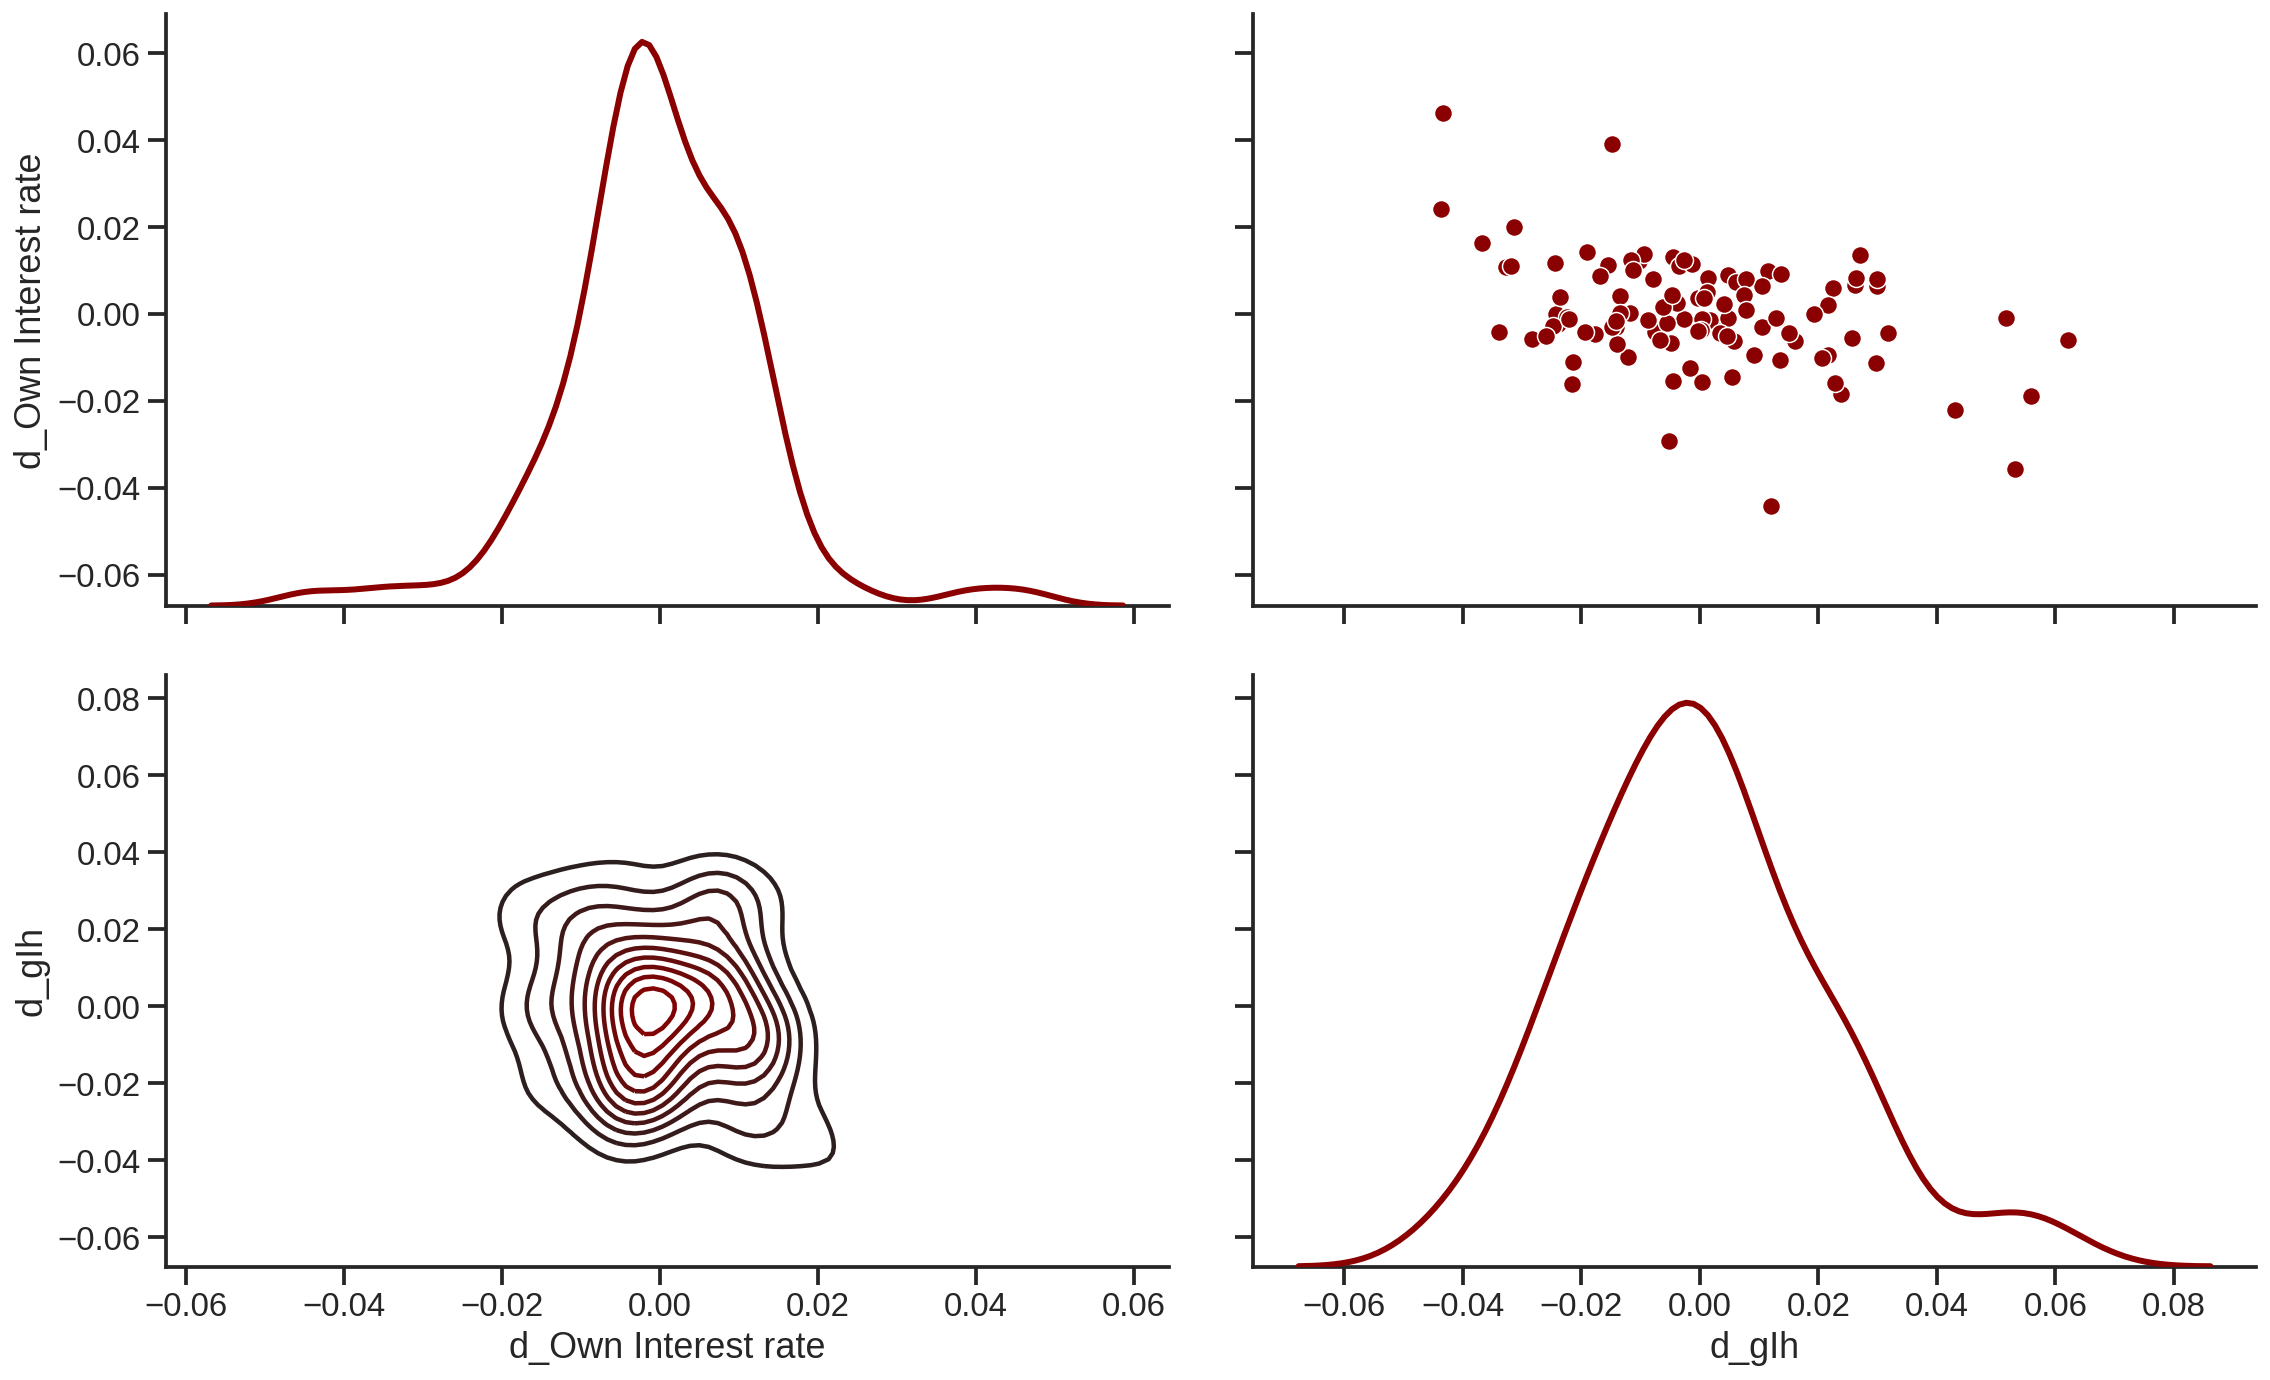

In [38]:
sns.set_context('talk')

g = sns.PairGrid(residuals, diag_sharey=False, height = 5, aspect=(8/5))
g.map_lower(sns.kdeplot, color = 'darkred')
g.map_upper(sns.scatterplot, color = 'darkred')
g.map_diag(sns.kdeplot, lw=3, color = 'darkred')
plt.show()
g.savefig("../figs/Residuos_4.eps", dpi = 600, )

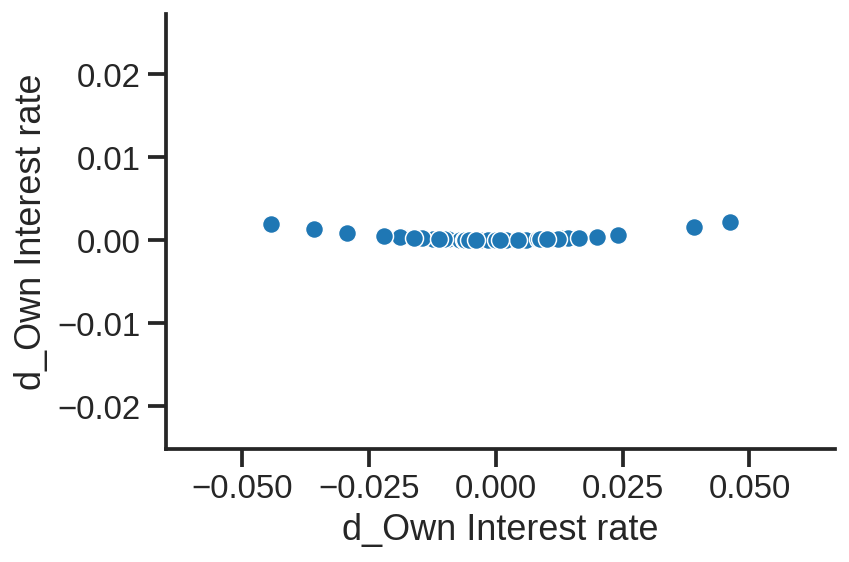

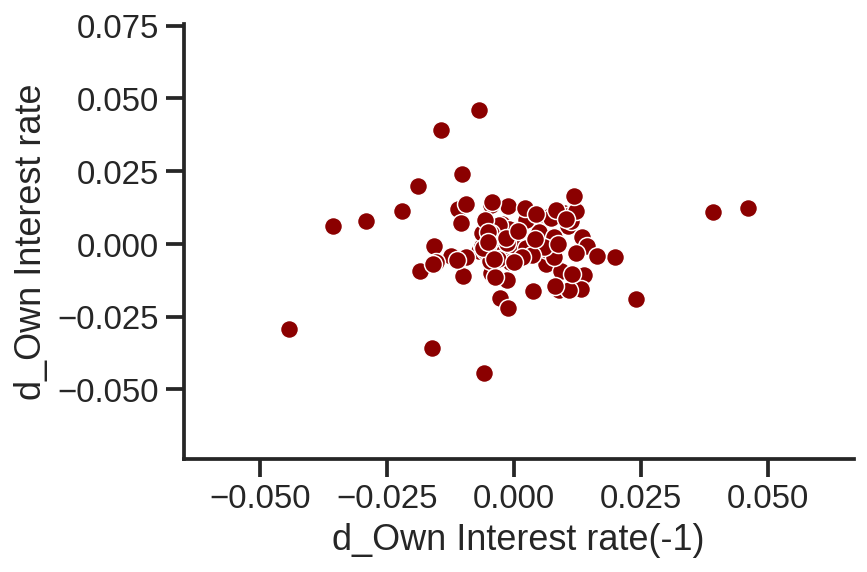

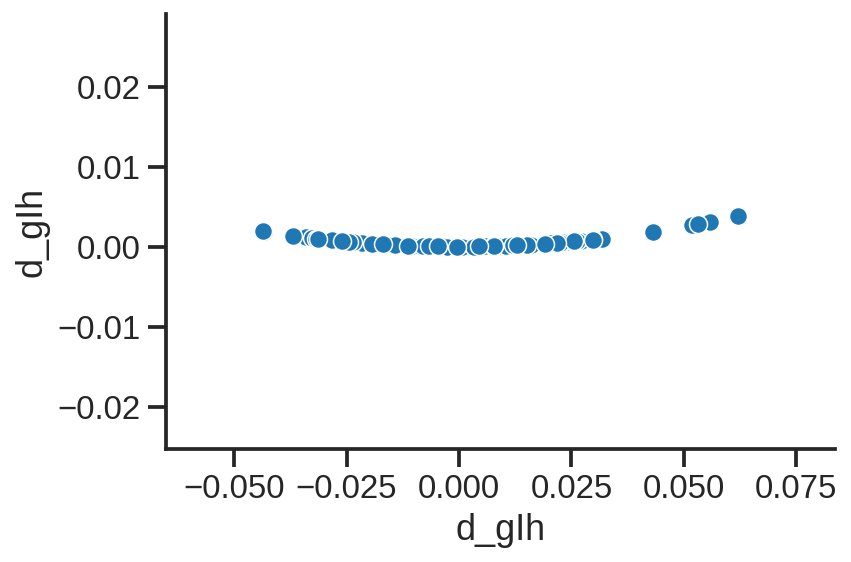

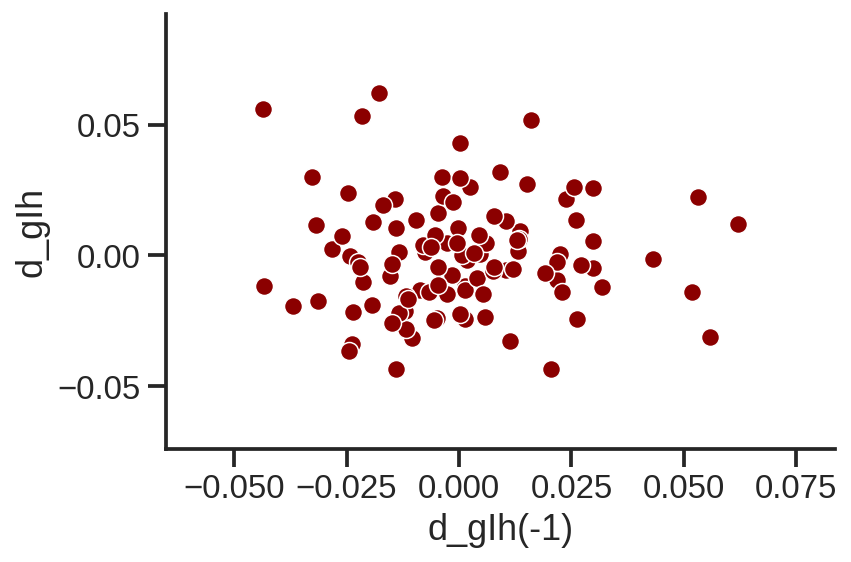

In [39]:
series = results.names
for serie in series:
    sns.scatterplot(x = residuals[serie], y = residuals[serie]**2)
    sns.despine()
    plt.show()
    
    sns.scatterplot(
    y = residuals[serie], 
    x = residuals[serie].shift(-1), 
    color = 'darkred' 
    )
    sns.despine()
    plt.xlabel(f"{serie}(-1)")
    plt.show()

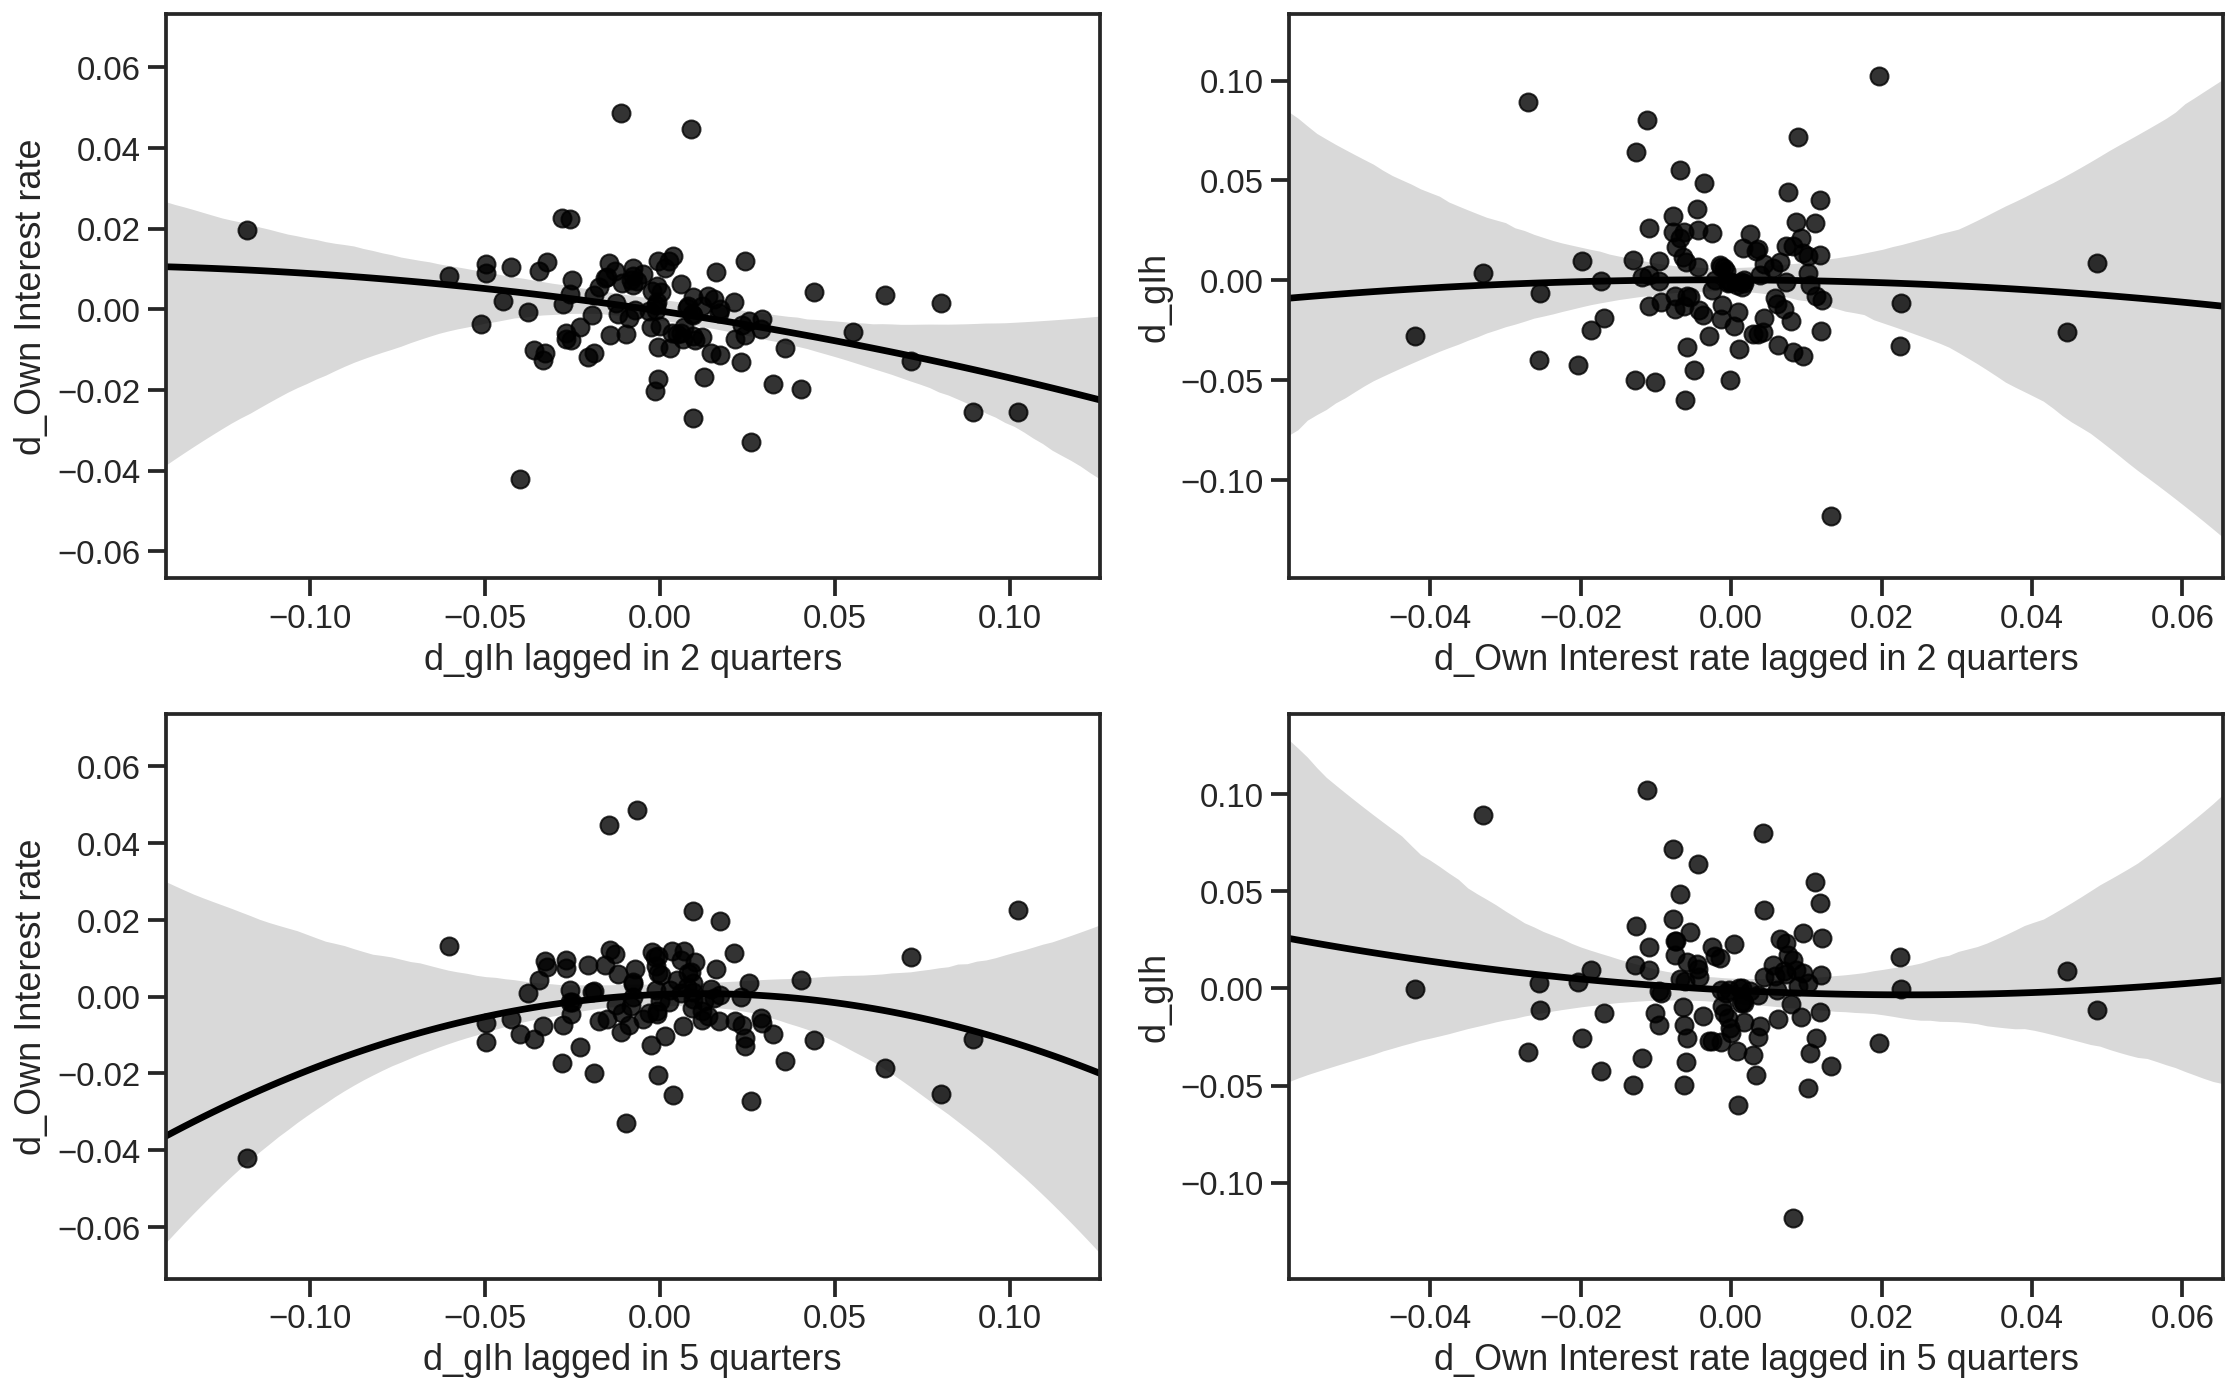

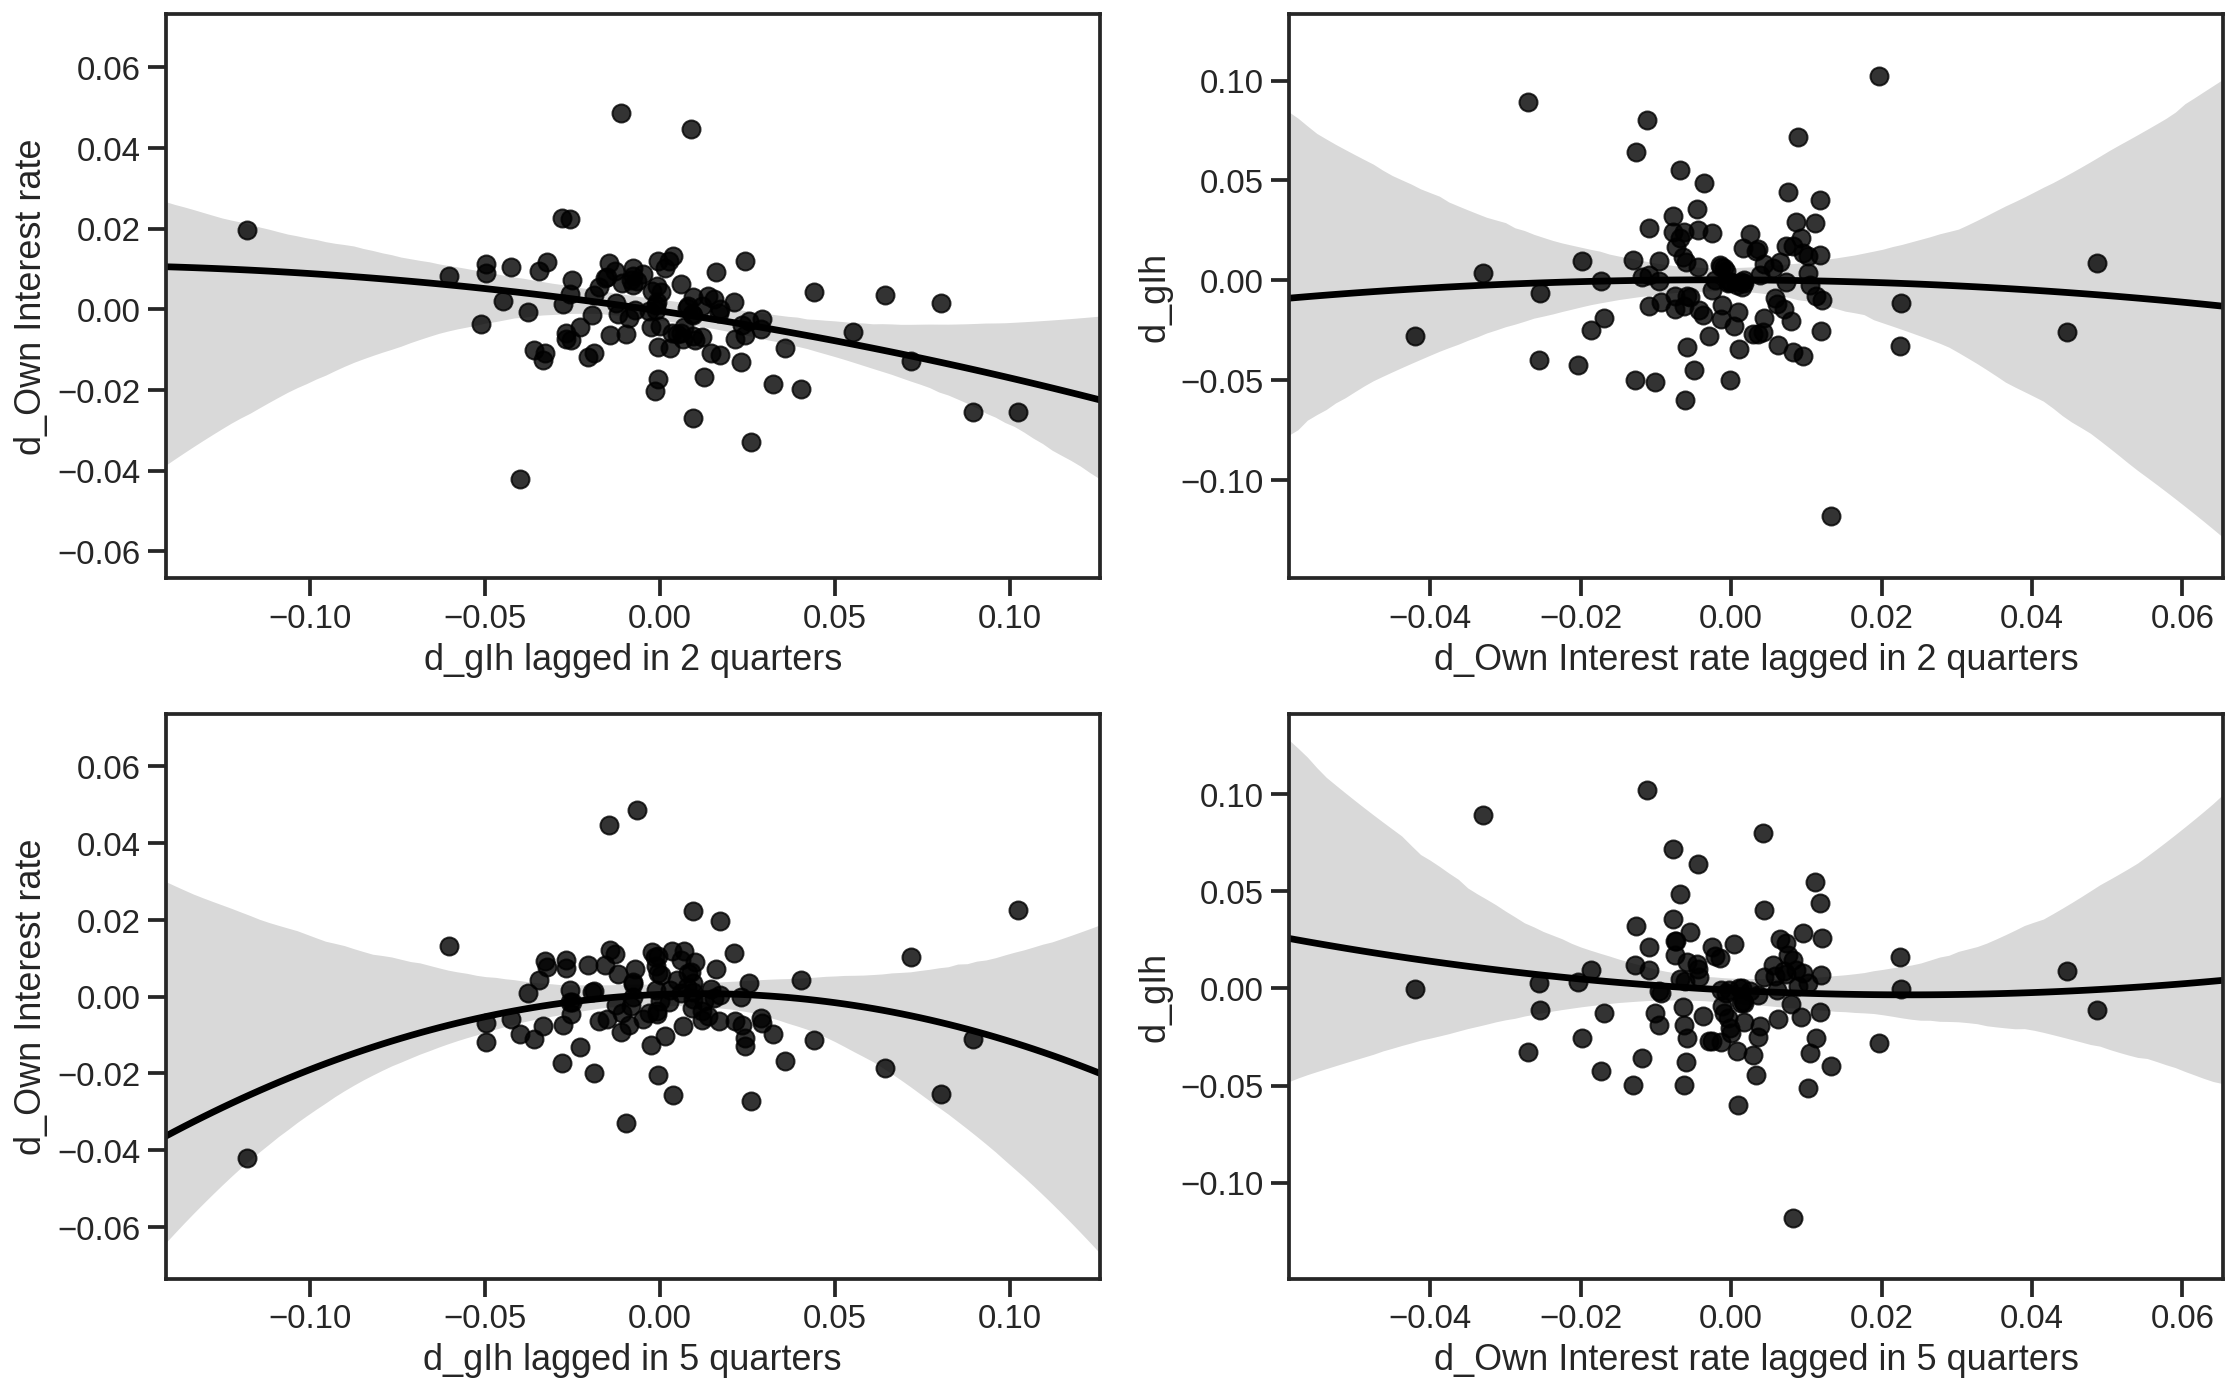

In [40]:
plot_lags(results=results)

## Função resposta ao Impulse ortogonalizada

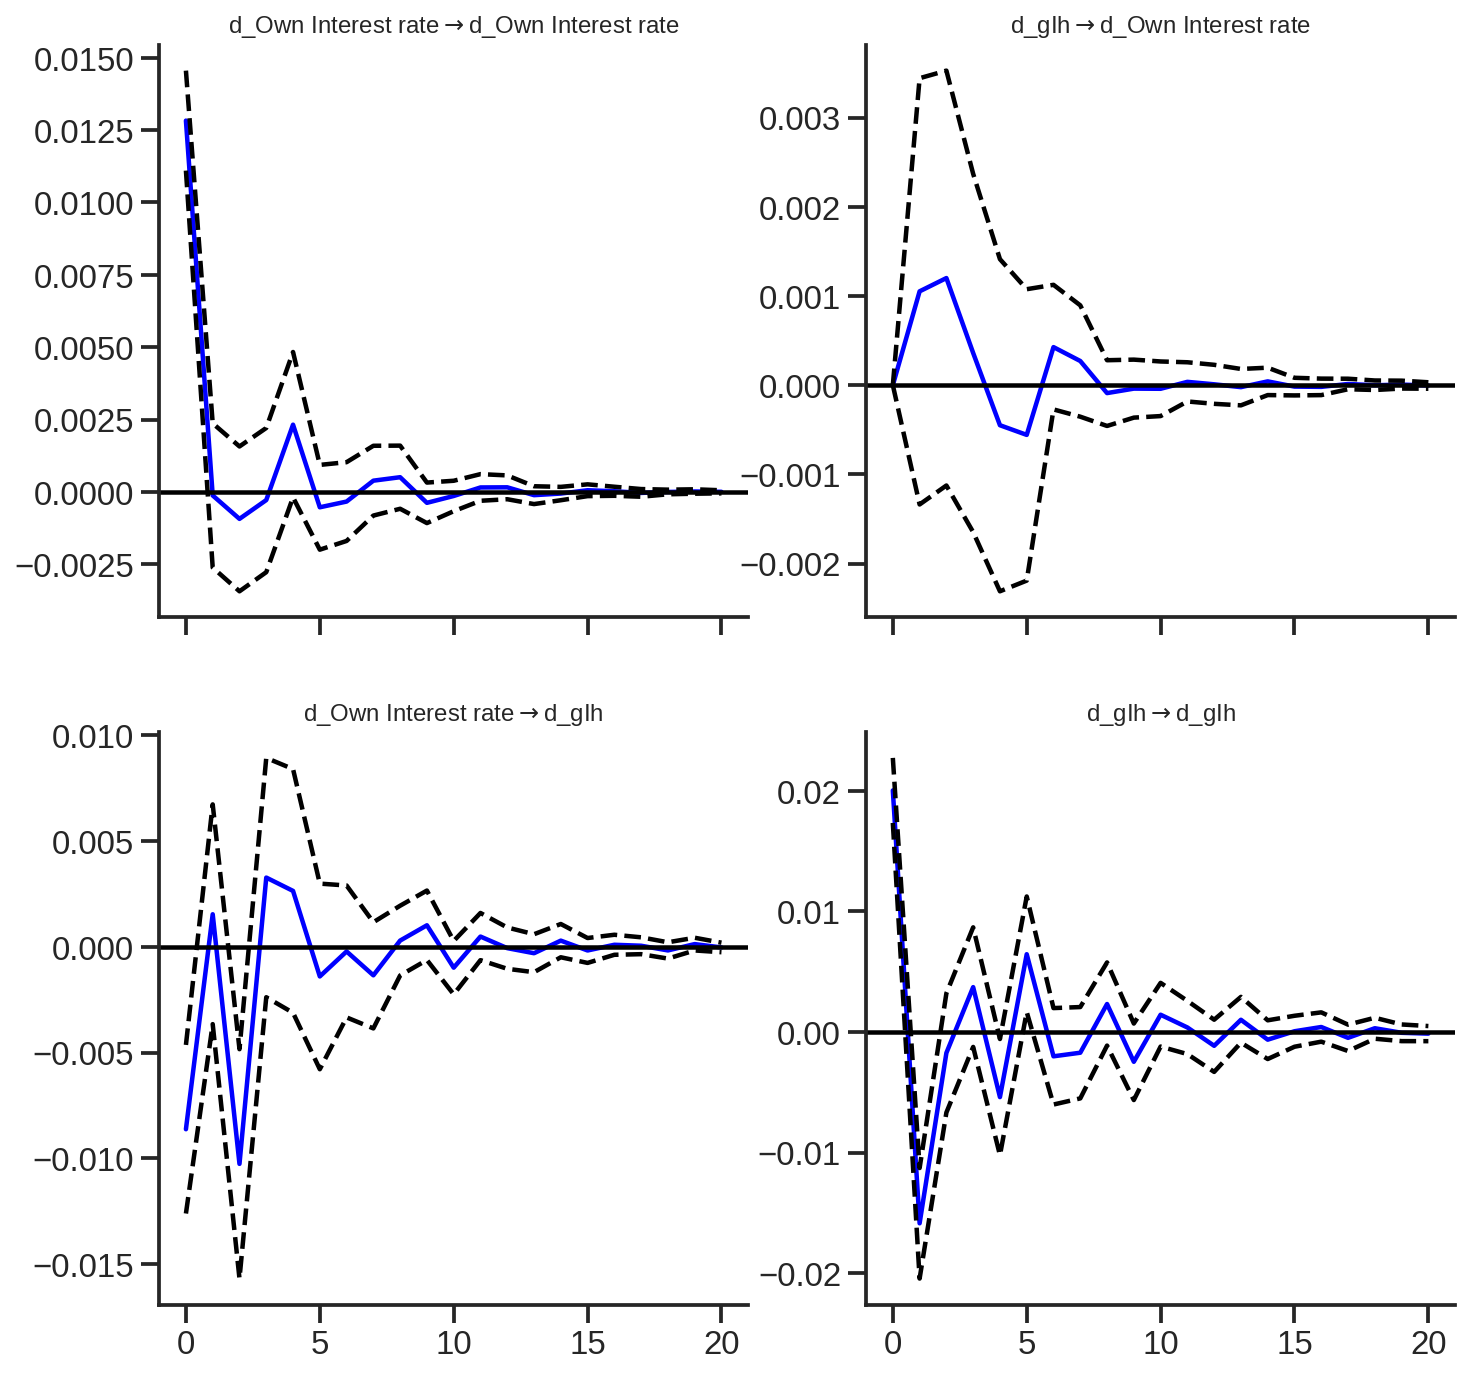

In [41]:
p = results.irf(20).plot(orth=True)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("../figs/Impulse_Orth.eps", dpi = 600)

## Função resposta ao Impulse não-ortogonalizada

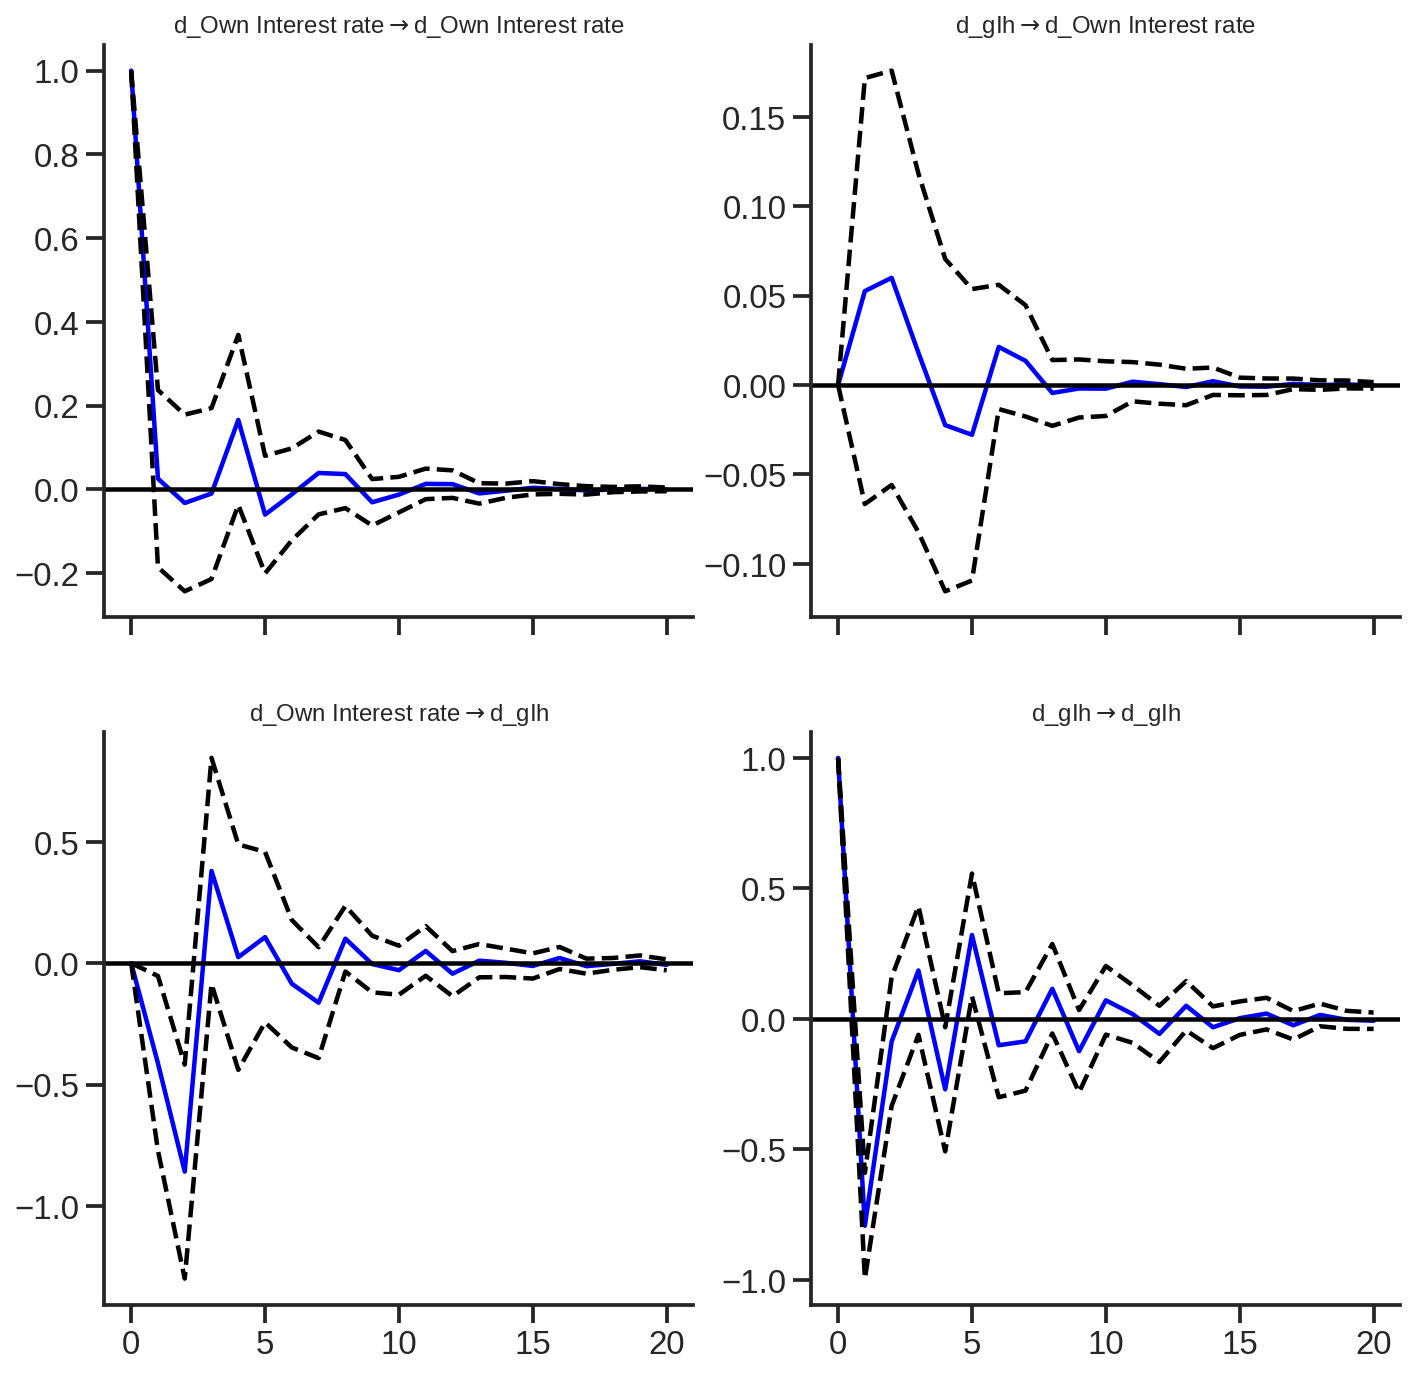

In [42]:
p = results.irf(20).plot(orth=False)
p.suptitle("")
sns.despine()
plt.show()
p.savefig("../figs/Impulse.eps", dpi = 600)

## Efeito cumulativo

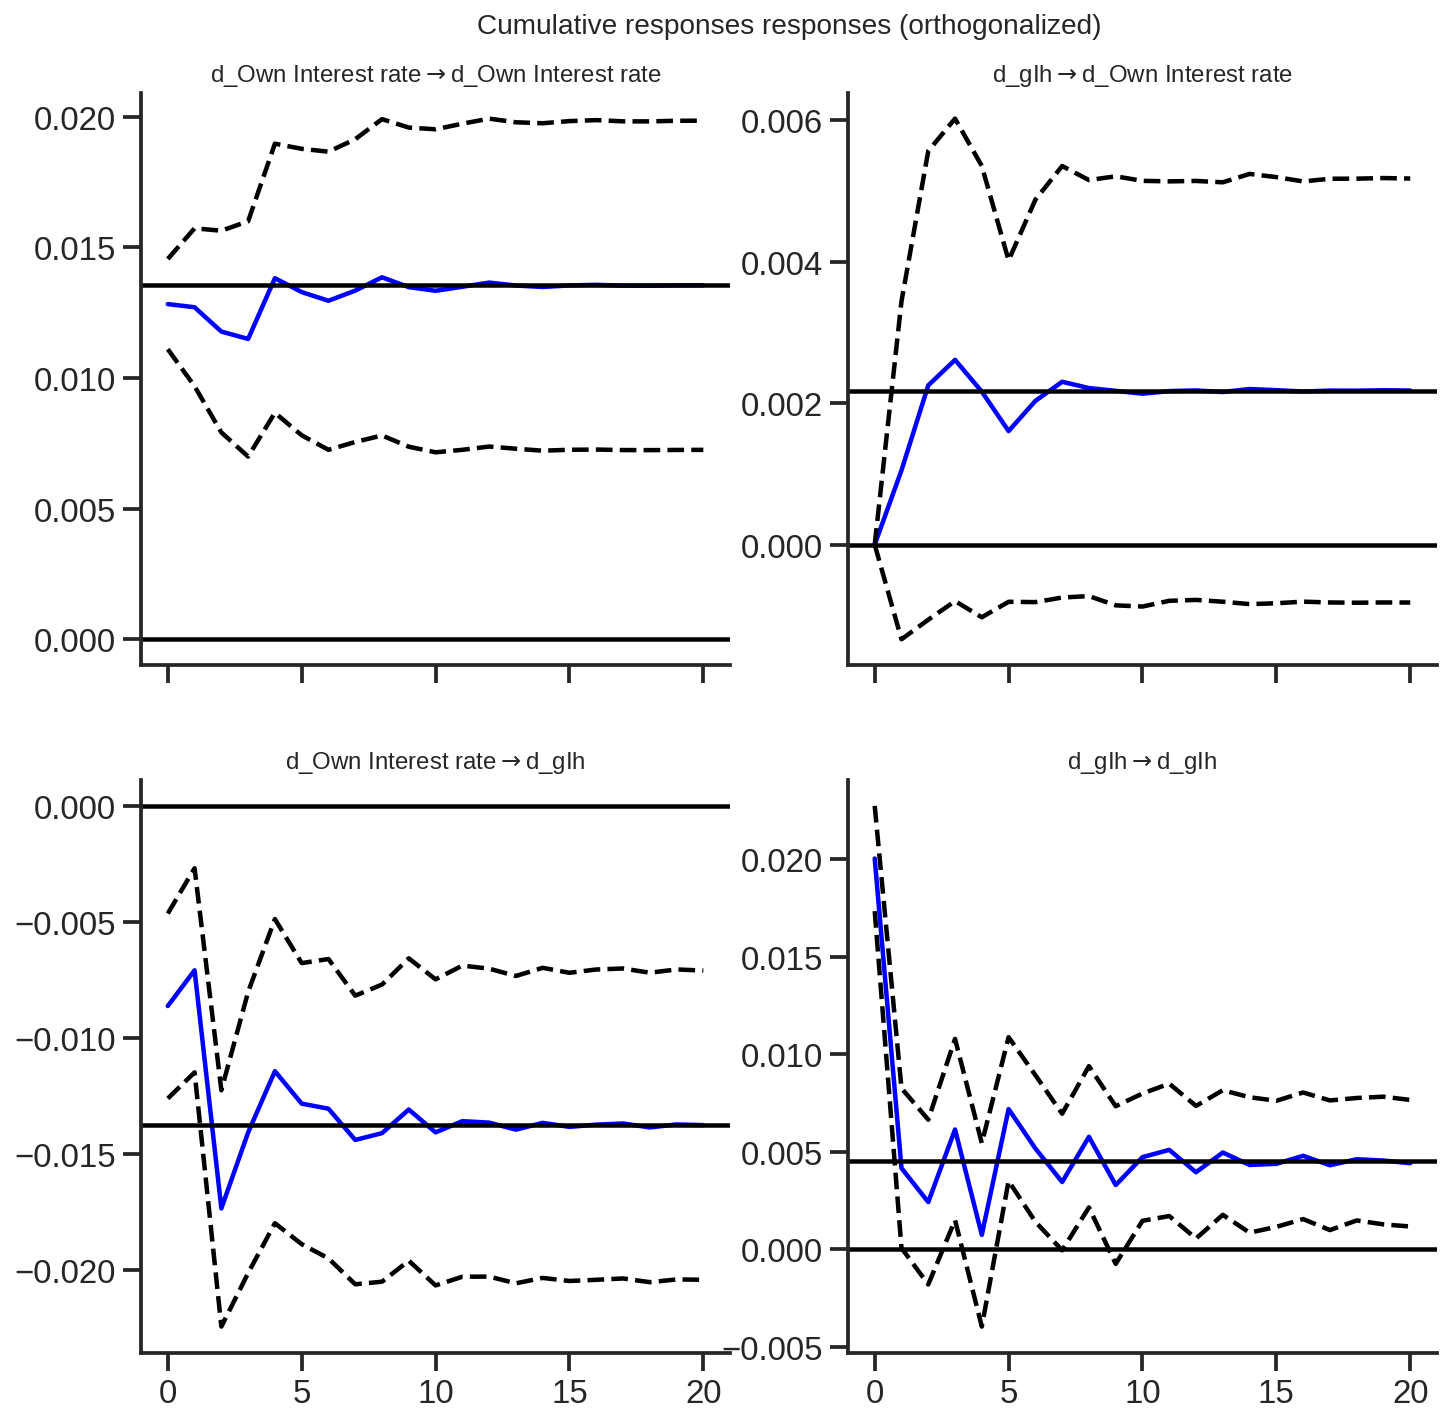

In [43]:
p = results.irf(20).plot_cum_effects(orth=True)
sns.despine()
plt.show()
p.savefig("../figs/Impulse_Cum.eps", dpi = 600)

## Decomposição da variância

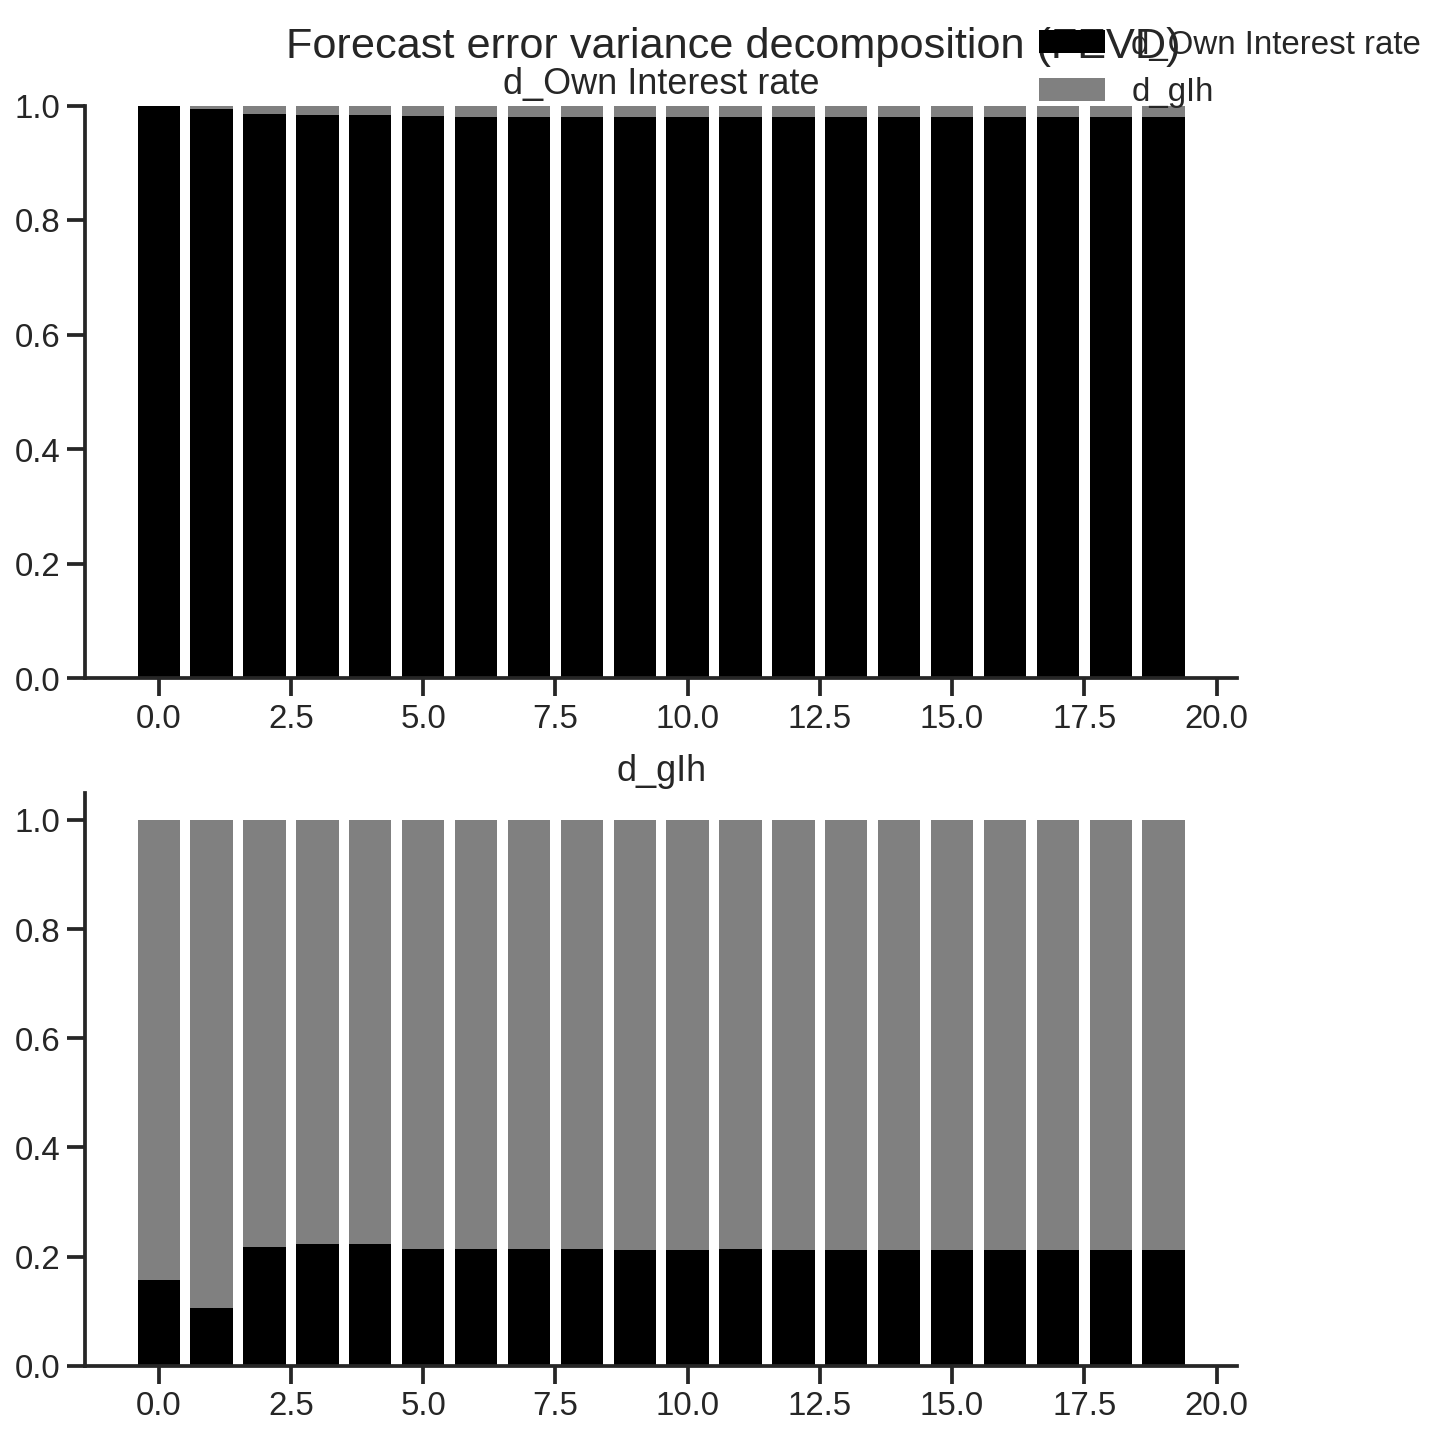

In [44]:
p = results.fevd(20).plot()
sns.despine()
plt.show()
p.savefig("../figs/DecompVar.eps", dpi = 600)